In [3]:
import numpy as np
import pandas as pd
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
from datetime import date,datetime
from dateutil.relativedelta import relativedelta
ticks = ['XLB','XLI','XLY','XLP', 'XLE','XLF','XLU','XLV','XLK']
end = date.today()
beg = end - relativedelta(years = 10)
data = pd.DataFrame(yf.download(ticks, start=beg, end=end)['Adj Close'])

[                       0%                       ]

[***********           22%                       ]  2 of 9 downloaded

[****************      33%                       ]  3 of 9 downloaded

[********************* 44%                       ]  4 of 9 downloaded

[**********************56%**                     ]  5 of 9 downloaded

[**********************67%*******                ]  6 of 9 downloaded

[**********************78%************           ]  7 of 9 downloaded

[**********************89%******************     ]  8 of 9 downloaded

[*********************100%***********************]  9 of 9 downloaded

[*********************100%***********************]  9 of 9 downloaded

In [5]:
#lets calc returns and cov matrix
rets = np.log(1+data.pct_change()).dropna()
mean_rets = rets.mean()*252
cov = rets.cov()*252
syms = len(ticks)


In [6]:
##now we simulate the returns of the portfolio across random samples
prets = []
pvols = []

for trial in range(20000):
    weights = np.random.random(syms)
    weights /= np.sum(weights)
    prets.append(np.sum(mean_rets*weights))
    pvols.append(np.sqrt(np.dot(weights.T,
                                np.dot(cov,weights))))
prets = np.array(prets)
pvols = np.array(pvols)

In [7]:
#function for computing portfolio returns, std, and shapre
def port_stats(weights):
    w = np.array(weights)
    r = np.sum(w*mean_rets)
    std = np.sqrt(np.dot(w.T,np.dot(cov,w)))
    sharpe = r/std
    return np.array([r,std,sharpe])

In [8]:
import scipy.optimize as sco
#boundaries
bnds = tuple((0,.3) for x in range(syms))
#constraints
cons = ({'type':'eq','fun':lambda x: np.sum(x)-1})

#returns negative of sharpe b/c minimum of negative sharpe is the maximum of the sharpe ratio
def max_sharpe(weights):
    return -port_stats(weights)[2]

guess = syms*[1/syms]
sharpe_opt = sco.minimize(max_sharpe, guess, method = 'SLSQP',constraints=cons, bounds=bnds)

#now lets find the min variance portfolio

def min_var(weights):
    return port_stats(weights)[1]

min_var_opt = sco.minimize(min_var, guess, method = 'SLSQP',constraints=cons, bounds=bnds)


In [9]:
#now lets create an efficient frontier for this dataset
frets = np.linspace(0.06, .13, 50)
fvols = []
for ret in frets:
    cons = ({'type':'eq', 'fun':lambda x: port_stats(x)[0]-ret},
            {'type':'eq','fun':lambda x: np.sum(x)-1})
    res = sco.minimize(min_var, guess, constraints = cons, bounds = bnds, method ='SLSQP')
    fvols.append(res['fun']) ## this is the actual vol
fvols = np.array(fvols)

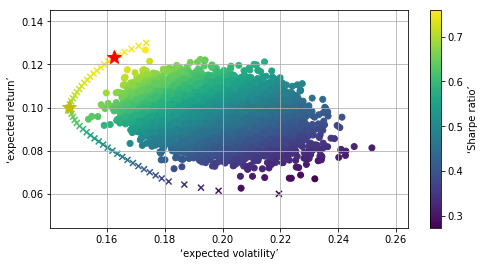

In [10]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
c=prets / pvols, marker='o')
# random portfolio composition
plt.scatter(fvols, frets,
c=frets / fvols, marker='x')
# efficient frontier
plt.plot(port_stats(sharpe_opt['x'])[1], port_stats(sharpe_opt['x'])[0],
'r*', markersize=15.0)
# portfolio with highest Sharpe ratio
plt.plot(port_stats(min_var_opt['x'])[1], port_stats(min_var_opt['x'])[0],
'y*', markersize=15.0)
# minimum variance portfolio
plt.grid(True)
plt.xlabel('‘expected volatility’')
plt.ylabel('‘expected return’')
plt.colorbar(label='‘Sharpe ratio’')

In [11]:
import scipy.interpolate as sci
##this code starts the interpolation at the minvar Portfolion
ind = np.argmin(fvols)
evols = fvols[ind:]
erets = frets[ind:]
tck = sci.splrep(evols, erets)

In [12]:
#define function
def f(x):
    return sci.splev(x,tck,der=0)
def df(x):
    return sci.splev(x,tck,der=1)

def CAPM_eq(p,rf=0.0175):
    eq1 = rf - p[0]
    eq2 = rf + p[1]*p[2]-f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1,eq2,eq3

#solivng the CAPM equation
CAPM_opt = sco.fsolve(CAPM_eq,[.0175,.5,.15])
CAPM_opt

array([0.0175    , 0.65177943, 0.16397355])

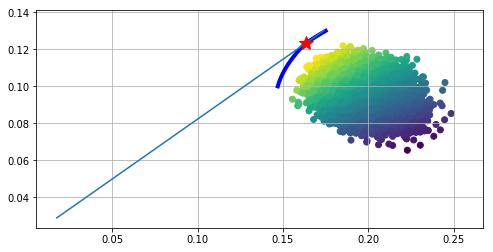

In [26]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
c=(prets - 0.01) / pvols, marker='o')
# random portfolio composition
plt.plot(evols, erets, 'b', lw=4.0)
rang = np.linspace(.0175,.174)
plt.plot(rang, CAPM_opt[0] + CAPM_opt[1]*rang)
plt.plot(CAPM_opt[2], f(CAPM_opt[2]), 'r*', markersize=15.0)
plt.grid(True)

In [13]:
#lets mess around with a rolling optimization portfolio
monthly_bm = pd.DataFrame(yf.download('BRK-B', start=beg, end=end)['Adj Close'])
monthly_bm = np.log(1+monthly_bm.pct_change())
monthly_bm = monthly_bm.resample('BM').asfreq().ffill()
monthly_bm.columns = ['Brk-B']
monthly = rets.resample('BM').asfreq().ffill()


[                       0%                       ]

[*********************100%***********************]  1 of 1 downloaded

In [58]:
lookback = 12
def quadfit(train,trainBM,test,testBM):
    syms = train.shape[1]
    #boundaries
    bnds = tuple((0,.1) for x in range(syms))
    #constraints
    cons = ({'type':'eq','fun':lambda x: np.sum(x)-1})
    guess = syms*[1/syms]
    
    #now lets find the min variance portfolio
    train_rets = train.mean()*12
    train_cov = train.cov()*12
    def port_stats(weights):
        w = np.array(weights)
        r = np.sum(w*train_rets)
        std = np.sqrt(np.dot(w.T,np.dot(train_cov,w)))
        sharpe = r/std
        return np.array([r,std,sharpe])
    max_sharpe_opt = sco.minimize(max_sharpe, guess, method = 'SLSQP',constraints=cons, bounds=bnds)
    weights = min_var_opt['x']
    test_rets = np.dot(weights,test)
    test_rets_bm = testBM
    cols = ticks+['Port Returns']+['Brk-B Returns']
    arr = np.hstack([weights,np.array(test_rets),test_rets_bm]).reshape(1,11)
    result = pd.DataFrame(arr,columns=cols)
    return result

In [61]:
minsim = lookback
maxsim = monthly.shape[0]

for sim in range(minsim,maxsim):
    train = monthly.iloc[sim-lookback:sim]
    print(train)
    train_bm = monthly_bm.iloc[sim-lookback:sim]
    test = monthly.iloc[sim]
    test_bm = monthly_bm.iloc[sim]
    result = quadfit(train,train_bm,test,test_bm)
    if sim == minsim:
        backtestWeights = result[ticks]
        backtestReturns = result[['Port Returns', 'Brk-B Returns']]
    else:
        backtestWeights = backtestWeights.append(result[ticks])
        backtestReturns = backtestReturns.append(result[['Port Returns', 'Brk-B Returns']])
    

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2008-08-29 -0.006769 -0.004678  0.001402 -0.011012 -0.022600 -0.009901   
2008-09-30  0.021181  0.059391  0.068670  0.009788  0.043765  0.034651   
2008-10-31  0.011251  0.020639  0.047471  0.032697 -0.005988 -0.006199   
2008-11-28  0.004329 -0.016177  0.024792  0.021431  0.001313  0.015070   
2008-12-31  0.017299  0.010522  0.031646  0.023765  0.012406  0.009682   
2009-01-30 -0.040024 -0.013969 -0.027749 -0.021599 -0.030194 -0.031114   
2009-02-27 -0.010272 -0.024497 -0.067412 -0.025406 -0.007057 -0.006365   
2009-03-31  0.004513 -0.008443  0.053626  0.005987  0.018741 -0.001894   
2009-04-30  0.027648 -0.016680 -0.013882  0.003683  0.002903 -0.004083   
2009-05-29  0.029507  0.018553  0.018152  0.023848  0.010823  0.010872   
2009-06-30 -0.009644 -0.006017 -0.009991 -0.010419 -0.007659 -0.007799   
2009-07-31  0.010356  0.009727  0.0100

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2008-09-30  0.021181  0.059391  0.068670  0.009788  0.043765  0.034651   
2008-10-31  0.011251  0.020639  0.047471  0.032697 -0.005988 -0.006199   
2008-11-28  0.004329 -0.016177  0.024792  0.021431  0.001313  0.015070   
2008-12-31  0.017299  0.010522  0.031646  0.023765  0.012406  0.009682   
2009-01-30 -0.040024 -0.013969 -0.027749 -0.021599 -0.030194 -0.031114   
2009-02-27 -0.010272 -0.024497 -0.067412 -0.025406 -0.007057 -0.006365   
2009-03-31  0.004513 -0.008443  0.053626  0.005987  0.018741 -0.001894   
2009-04-30  0.027648 -0.016680 -0.013882  0.003683  0.002903 -0.004083   
2009-05-29  0.029507  0.018553  0.018152  0.023848  0.010823  0.010872   
2009-06-30 -0.009644 -0.006017 -0.009991 -0.010419 -0.007659 -0.007799   
2009-07-31  0.010356  0.009727  0.010042  0.003776 -0.003547 -0.002037   
2009-08-31 -0.013329 -0.019546 -0.0033

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2008-10-31  0.011251  0.020639  0.047471  0.032697 -0.005988 -0.006199   
2008-11-28  0.004329 -0.016177  0.024792  0.021431  0.001313  0.015070   
2008-12-31  0.017299  0.010522  0.031646  0.023765  0.012406  0.009682   
2009-01-30 -0.040024 -0.013969 -0.027749 -0.021599 -0.030194 -0.031114   
2009-02-27 -0.010272 -0.024497 -0.067412 -0.025406 -0.007057 -0.006365   
2009-03-31  0.004513 -0.008443  0.053626  0.005987  0.018741 -0.001894   
2009-04-30  0.027648 -0.016680 -0.013882  0.003683  0.002903 -0.004083   
2009-05-29  0.029507  0.018553  0.018152  0.023848  0.010823  0.010872   
2009-06-30 -0.009644 -0.006017 -0.009991 -0.010419 -0.007659 -0.007799   
2009-07-31  0.010356  0.009727  0.010042  0.003776 -0.003547 -0.002037   
2009-08-31 -0.013329 -0.019546 -0.003396 -0.011919 -0.012903  0.002017   
2009-09-30 -0.006764 -0.006471 -0.0046

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2008-11-28  0.004329 -0.016177  0.024792  0.021431  0.001313  0.015070   
2008-12-31  0.017299  0.010522  0.031646  0.023765  0.012406  0.009682   
2009-01-30 -0.040024 -0.013969 -0.027749 -0.021599 -0.030194 -0.031114   
2009-02-27 -0.010272 -0.024497 -0.067412 -0.025406 -0.007057 -0.006365   
2009-03-31  0.004513 -0.008443  0.053626  0.005987  0.018741 -0.001894   
2009-04-30  0.027648 -0.016680 -0.013882  0.003683  0.002903 -0.004083   
2009-05-29  0.029507  0.018553  0.018152  0.023848  0.010823  0.010872   
2009-06-30 -0.009644 -0.006017 -0.009991 -0.010419 -0.007659 -0.007799   
2009-07-31  0.010356  0.009727  0.010042  0.003776 -0.003547 -0.002037   
2009-08-31 -0.013329 -0.019546 -0.003396 -0.011919 -0.012903  0.002017   
2009-09-30 -0.006764 -0.006471 -0.004674 -0.010199  0.002879  0.001966   
2009-10-30 -0.036477 -0.038698 -0.0479

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2008-12-31  0.017299  0.010522  0.031646  0.023765  0.012406  0.009682   
2009-01-30 -0.040024 -0.013969 -0.027749 -0.021599 -0.030194 -0.031114   
2009-02-27 -0.010272 -0.024497 -0.067412 -0.025406 -0.007057 -0.006365   
2009-03-31  0.004513 -0.008443  0.053626  0.005987  0.018741 -0.001894   
2009-04-30  0.027648 -0.016680 -0.013882  0.003683  0.002903 -0.004083   
2009-05-29  0.029507  0.018553  0.018152  0.023848  0.010823  0.010872   
2009-06-30 -0.009644 -0.006017 -0.009991 -0.010419 -0.007659 -0.007799   
2009-07-31  0.010356  0.009727  0.010042  0.003776 -0.003547 -0.002037   
2009-08-31 -0.013329 -0.019546 -0.003396 -0.011919 -0.012903  0.002017   
2009-09-30 -0.006764 -0.006471 -0.004674 -0.010199  0.002879  0.001966   
2009-10-30 -0.036477 -0.038698 -0.047943 -0.034587 -0.026809 -0.015749   
2009-11-30  0.004626 -0.003514  0.0262

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2009-01-30 -0.040024 -0.013969 -0.027749 -0.021599 -0.030194 -0.031114   
2009-02-27 -0.010272 -0.024497 -0.067412 -0.025406 -0.007057 -0.006365   
2009-03-31  0.004513 -0.008443  0.053626  0.005987  0.018741 -0.001894   
2009-04-30  0.027648 -0.016680 -0.013882  0.003683  0.002903 -0.004083   
2009-05-29  0.029507  0.018553  0.018152  0.023848  0.010823  0.010872   
2009-06-30 -0.009644 -0.006017 -0.009991 -0.010419 -0.007659 -0.007799   
2009-07-31  0.010356  0.009727  0.010042  0.003776 -0.003547 -0.002037   
2009-08-31 -0.013329 -0.019546 -0.003396 -0.011919 -0.012903  0.002017   
2009-09-30 -0.006764 -0.006471 -0.004674 -0.010199  0.002879  0.001966   
2009-10-30 -0.036477 -0.038698 -0.047943 -0.034587 -0.026809 -0.015749   
2009-11-30  0.004626 -0.003514  0.026262  0.003277  0.001841 -0.003728   
2009-12-31 -0.013847 -0.008037 -0.0020

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2009-02-27 -0.010272 -0.024497 -0.067412 -0.025406 -0.007057 -0.006365   
2009-03-31  0.004513 -0.008443  0.053626  0.005987  0.018741 -0.001894   
2009-04-30  0.027648 -0.016680 -0.013882  0.003683  0.002903 -0.004083   
2009-05-29  0.029507  0.018553  0.018152  0.023848  0.010823  0.010872   
2009-06-30 -0.009644 -0.006017 -0.009991 -0.010419 -0.007659 -0.007799   
2009-07-31  0.010356  0.009727  0.010042  0.003776 -0.003547 -0.002037   
2009-08-31 -0.013329 -0.019546 -0.003396 -0.011919 -0.012903  0.002017   
2009-09-30 -0.006764 -0.006471 -0.004674 -0.010199  0.002879  0.001966   
2009-10-30 -0.036477 -0.038698 -0.047943 -0.034587 -0.026809 -0.015749   
2009-11-30  0.004626 -0.003514  0.026262  0.003277  0.001841 -0.003728   
2009-12-31 -0.013847 -0.008037 -0.002081 -0.012516 -0.008684 -0.009775   
2010-01-29 -0.016127 -0.018182 -0.0070

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2009-04-30  0.027648 -0.016680 -0.013882  0.003683  0.002903 -0.004083   
2009-05-29  0.029507  0.018553  0.018152  0.023848  0.010823  0.010872   
2009-06-30 -0.009644 -0.006017 -0.009991 -0.010419 -0.007659 -0.007799   
2009-07-31  0.010356  0.009727  0.010042  0.003776 -0.003547 -0.002037   
2009-08-31 -0.013329 -0.019546 -0.003396 -0.011919 -0.012903  0.002017   
2009-09-30 -0.006764 -0.006471 -0.004674 -0.010199  0.002879  0.001966   
2009-10-30 -0.036477 -0.038698 -0.047943 -0.034587 -0.026809 -0.015749   
2009-11-30  0.004626 -0.003514  0.026262  0.003277  0.001841 -0.003728   
2009-12-31 -0.013847 -0.008037 -0.002081 -0.012516 -0.008684 -0.009775   
2010-01-29 -0.016127 -0.018182 -0.007027 -0.010174 -0.017498 -0.003810   
2010-02-26  0.000318  0.002318  0.006149  0.003821  0.001384 -0.004798   
2010-03-31 -0.005000  0.004530  0.0018

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2009-05-29  0.029507  0.018553  0.018152  0.023848  0.010823  0.010872   
2009-06-30 -0.009644 -0.006017 -0.009991 -0.010419 -0.007659 -0.007799   
2009-07-31  0.010356  0.009727  0.010042  0.003776 -0.003547 -0.002037   
2009-08-31 -0.013329 -0.019546 -0.003396 -0.011919 -0.012903  0.002017   
2009-09-30 -0.006764 -0.006471 -0.004674 -0.010199  0.002879  0.001966   
2009-10-30 -0.036477 -0.038698 -0.047943 -0.034587 -0.026809 -0.015749   
2009-11-30  0.004626 -0.003514  0.026262  0.003277  0.001841 -0.003728   
2009-12-31 -0.013847 -0.008037 -0.002081 -0.012516 -0.008684 -0.009775   
2010-01-29 -0.016127 -0.018182 -0.007027 -0.010174 -0.017498 -0.003810   
2010-02-26  0.000318  0.002318  0.006149  0.003821  0.001384 -0.004798   
2010-03-31 -0.005000  0.004530  0.001883 -0.005745 -0.003026 -0.005713   
2010-04-30 -0.017787 -0.012441 -0.0244

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2009-06-30 -0.009644 -0.006017 -0.009991 -0.010419 -0.007659 -0.007799   
2009-07-31  0.010356  0.009727  0.010042  0.003776 -0.003547 -0.002037   
2009-08-31 -0.013329 -0.019546 -0.003396 -0.011919 -0.012903  0.002017   
2009-09-30 -0.006764 -0.006471 -0.004674 -0.010199  0.002879  0.001966   
2009-10-30 -0.036477 -0.038698 -0.047943 -0.034587 -0.026809 -0.015749   
2009-11-30  0.004626 -0.003514  0.026262  0.003277  0.001841 -0.003728   
2009-12-31 -0.013847 -0.008037 -0.002081 -0.012516 -0.008684 -0.009775   
2010-01-29 -0.016127 -0.018182 -0.007027 -0.010174 -0.017498 -0.003810   
2010-02-26  0.000318  0.002318  0.006149  0.003821  0.001384 -0.004798   
2010-03-31 -0.005000  0.004530  0.001883 -0.005745 -0.003026 -0.005713   
2010-04-30 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-05-31 -0.017787 -0.012441 -0.0244

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2009-07-31  0.010356  0.009727  0.010042  0.003776 -0.003547 -0.002037   
2009-08-31 -0.013329 -0.019546 -0.003396 -0.011919 -0.012903  0.002017   
2009-09-30 -0.006764 -0.006471 -0.004674 -0.010199  0.002879  0.001966   
2009-10-30 -0.036477 -0.038698 -0.047943 -0.034587 -0.026809 -0.015749   
2009-11-30  0.004626 -0.003514  0.026262  0.003277  0.001841 -0.003728   
2009-12-31 -0.013847 -0.008037 -0.002081 -0.012516 -0.008684 -0.009775   
2010-01-29 -0.016127 -0.018182 -0.007027 -0.010174 -0.017498 -0.003810   
2010-02-26  0.000318  0.002318  0.006149  0.003821  0.001384 -0.004798   
2010-03-31 -0.005000  0.004530  0.001883 -0.005745 -0.003026 -0.005713   
2010-04-30 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-05-31 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-06-30 -0.010170 -0.007819 -0.0122

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2009-08-31 -0.013329 -0.019546 -0.003396 -0.011919 -0.012903  0.002017   
2009-09-30 -0.006764 -0.006471 -0.004674 -0.010199  0.002879  0.001966   
2009-10-30 -0.036477 -0.038698 -0.047943 -0.034587 -0.026809 -0.015749   
2009-11-30  0.004626 -0.003514  0.026262  0.003277  0.001841 -0.003728   
2009-12-31 -0.013847 -0.008037 -0.002081 -0.012516 -0.008684 -0.009775   
2010-01-29 -0.016127 -0.018182 -0.007027 -0.010174 -0.017498 -0.003810   
2010-02-26  0.000318  0.002318  0.006149  0.003821  0.001384 -0.004798   
2010-03-31 -0.005000  0.004530  0.001883 -0.005745 -0.003026 -0.005713   
2010-04-30 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-05-31 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-06-30 -0.010170 -0.007819 -0.012235 -0.006541 -0.015564 -0.007034   
2010-07-30  0.006268 -0.002041 -0.0006

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2009-09-30 -0.006764 -0.006471 -0.004674 -0.010199  0.002879  0.001966   
2009-10-30 -0.036477 -0.038698 -0.047943 -0.034587 -0.026809 -0.015749   
2009-11-30  0.004626 -0.003514  0.026262  0.003277  0.001841 -0.003728   
2009-12-31 -0.013847 -0.008037 -0.002081 -0.012516 -0.008684 -0.009775   
2010-01-29 -0.016127 -0.018182 -0.007027 -0.010174 -0.017498 -0.003810   
2010-02-26  0.000318  0.002318  0.006149  0.003821  0.001384 -0.004798   
2010-03-31 -0.005000  0.004530  0.001883 -0.005745 -0.003026 -0.005713   
2010-04-30 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-05-31 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-06-30 -0.010170 -0.007819 -0.012235 -0.006541 -0.015564 -0.007034   
2010-07-30  0.006268 -0.002041 -0.000680  0.003969 -0.004097  0.002598   
2010-08-31  0.004197 -0.002731  0.0088

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2009-10-30 -0.036477 -0.038698 -0.047943 -0.034587 -0.026809 -0.015749   
2009-11-30  0.004626 -0.003514  0.026262  0.003277  0.001841 -0.003728   
2009-12-31 -0.013847 -0.008037 -0.002081 -0.012516 -0.008684 -0.009775   
2010-01-29 -0.016127 -0.018182 -0.007027 -0.010174 -0.017498 -0.003810   
2010-02-26  0.000318  0.002318  0.006149  0.003821  0.001384 -0.004798   
2010-03-31 -0.005000  0.004530  0.001883 -0.005745 -0.003026 -0.005713   
2010-04-30 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-05-31 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-06-30 -0.010170 -0.007819 -0.012235 -0.006541 -0.015564 -0.007034   
2010-07-30  0.006268 -0.002041 -0.000680  0.003969 -0.004097  0.002598   
2010-08-31  0.004197 -0.002731  0.008889 -0.003895 -0.003377  0.000755   
2010-09-30 -0.003958  0.000357 -0.0013

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2009-11-30  0.004626 -0.003514  0.026262  0.003277  0.001841 -0.003728   
2009-12-31 -0.013847 -0.008037 -0.002081 -0.012516 -0.008684 -0.009775   
2010-01-29 -0.016127 -0.018182 -0.007027 -0.010174 -0.017498 -0.003810   
2010-02-26  0.000318  0.002318  0.006149  0.003821  0.001384 -0.004798   
2010-03-31 -0.005000  0.004530  0.001883 -0.005745 -0.003026 -0.005713   
2010-04-30 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-05-31 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-06-30 -0.010170 -0.007819 -0.012235 -0.006541 -0.015564 -0.007034   
2010-07-30  0.006268 -0.002041 -0.000680  0.003969 -0.004097  0.002598   
2010-08-31  0.004197 -0.002731  0.008889 -0.003895 -0.003377  0.000755   
2010-09-30 -0.003958  0.000357 -0.001393 -0.003829 -0.003902 -0.003580   
2010-10-29  0.008078  0.000676 -0.0013

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2009-12-31 -0.013847 -0.008037 -0.002081 -0.012516 -0.008684 -0.009775   
2010-01-29 -0.016127 -0.018182 -0.007027 -0.010174 -0.017498 -0.003810   
2010-02-26  0.000318  0.002318  0.006149  0.003821  0.001384 -0.004798   
2010-03-31 -0.005000  0.004530  0.001883 -0.005745 -0.003026 -0.005713   
2010-04-30 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-05-31 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-06-30 -0.010170 -0.007819 -0.012235 -0.006541 -0.015564 -0.007034   
2010-07-30  0.006268 -0.002041 -0.000680  0.003969 -0.004097  0.002598   
2010-08-31  0.004197 -0.002731  0.008889 -0.003895 -0.003377  0.000755   
2010-09-30 -0.003958  0.000357 -0.001393 -0.003829 -0.003902 -0.003580   
2010-10-29  0.008078  0.000676 -0.001373  0.001555  0.001644  0.003482   
2010-11-30  0.000569 -0.003502 -0.0055

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-01-29 -0.016127 -0.018182 -0.007027 -0.010174 -0.017498 -0.003810   
2010-02-26  0.000318  0.002318  0.006149  0.003821  0.001384 -0.004798   
2010-03-31 -0.005000  0.004530  0.001883 -0.005745 -0.003026 -0.005713   
2010-04-30 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-05-31 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-06-30 -0.010170 -0.007819 -0.012235 -0.006541 -0.015564 -0.007034   
2010-07-30  0.006268 -0.002041 -0.000680  0.003969 -0.004097  0.002598   
2010-08-31  0.004197 -0.002731  0.008889 -0.003895 -0.003377  0.000755   
2010-09-30 -0.003958  0.000357 -0.001393 -0.003829 -0.003902 -0.003580   
2010-10-29  0.008078  0.000676 -0.001373  0.001555  0.001644  0.003482   
2010-11-30  0.000569 -0.003502 -0.005517 -0.002450 -0.009971 -0.004580   
2010-12-31 -0.000781  0.001466  0.0012

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-02-26  0.000318  0.002318  0.006149  0.003821  0.001384 -0.004798   
2010-03-31 -0.005000  0.004530  0.001883 -0.005745 -0.003026 -0.005713   
2010-04-30 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-05-31 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-06-30 -0.010170 -0.007819 -0.012235 -0.006541 -0.015564 -0.007034   
2010-07-30  0.006268 -0.002041 -0.000680  0.003969 -0.004097  0.002598   
2010-08-31  0.004197 -0.002731  0.008889 -0.003895 -0.003377  0.000755   
2010-09-30 -0.003958  0.000357 -0.001393 -0.003829 -0.003902 -0.003580   
2010-10-29  0.008078  0.000676 -0.001373  0.001555  0.001644  0.003482   
2010-11-30  0.000569 -0.003502 -0.005517 -0.002450 -0.009971 -0.004580   
2010-12-31 -0.000781  0.001466  0.001255  0.001148 -0.001190  0.000341   
2011-01-31  0.016525  0.028284  0.0091

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-03-31 -0.005000  0.004530  0.001883 -0.005745 -0.003026 -0.005713   
2010-04-30 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-05-31 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-06-30 -0.010170 -0.007819 -0.012235 -0.006541 -0.015564 -0.007034   
2010-07-30  0.006268 -0.002041 -0.000680  0.003969 -0.004097  0.002598   
2010-08-31  0.004197 -0.002731  0.008889 -0.003895 -0.003377  0.000755   
2010-09-30 -0.003958  0.000357 -0.001393 -0.003829 -0.003902 -0.003580   
2010-10-29  0.008078  0.000676 -0.001373  0.001555  0.001644  0.003482   
2010-11-30  0.000569 -0.003502 -0.005517 -0.002450 -0.009971 -0.004580   
2010-12-31 -0.000781  0.001466  0.001255  0.001148 -0.001190  0.000341   
2011-01-31  0.016525  0.028284  0.009188  0.011378  0.006175 -0.003457   
2011-02-28  0.010701  0.007669  0.0047

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-04-30 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-05-31 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-06-30 -0.010170 -0.007819 -0.012235 -0.006541 -0.015564 -0.007034   
2010-07-30  0.006268 -0.002041 -0.000680  0.003969 -0.004097  0.002598   
2010-08-31  0.004197 -0.002731  0.008889 -0.003895 -0.003377  0.000755   
2010-09-30 -0.003958  0.000357 -0.001393 -0.003829 -0.003902 -0.003580   
2010-10-29  0.008078  0.000676 -0.001373  0.001555  0.001644  0.003482   
2010-11-30  0.000569 -0.003502 -0.005517 -0.002450 -0.009971 -0.004580   
2010-12-31 -0.000781  0.001466  0.001255  0.001148 -0.001190  0.000341   
2011-01-31  0.016525  0.028284  0.009188  0.011378  0.006175 -0.003457   
2011-02-28  0.010701  0.007669  0.004759  0.004875  0.004150  0.005736   
2011-03-31  0.003755 -0.003255 -0.0036

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-05-31 -0.017787 -0.012441 -0.024452 -0.023966 -0.021151 -0.005774   
2010-06-30 -0.010170 -0.007819 -0.012235 -0.006541 -0.015564 -0.007034   
2010-07-30  0.006268 -0.002041 -0.000680  0.003969 -0.004097  0.002598   
2010-08-31  0.004197 -0.002731  0.008889 -0.003895 -0.003377  0.000755   
2010-09-30 -0.003958  0.000357 -0.001393 -0.003829 -0.003902 -0.003580   
2010-10-29  0.008078  0.000676 -0.001373  0.001555  0.001644  0.003482   
2010-11-30  0.000569 -0.003502 -0.005517 -0.002450 -0.009971 -0.004580   
2010-12-31 -0.000781  0.001466  0.001255  0.001148 -0.001190  0.000341   
2011-01-31  0.016525  0.028284  0.009188  0.011378  0.006175 -0.003457   
2011-02-28  0.010701  0.007669  0.004759  0.004875  0.004150  0.005736   
2011-03-31  0.003755 -0.003255 -0.003654  0.003990 -0.001917 -0.002003   
2011-04-29  0.003922  0.014770 -0.0018

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-06-30 -0.010170 -0.007819 -0.012235 -0.006541 -0.015564 -0.007034   
2010-07-30  0.006268 -0.002041 -0.000680  0.003969 -0.004097  0.002598   
2010-08-31  0.004197 -0.002731  0.008889 -0.003895 -0.003377  0.000755   
2010-09-30 -0.003958  0.000357 -0.001393 -0.003829 -0.003902 -0.003580   
2010-10-29  0.008078  0.000676 -0.001373  0.001555  0.001644  0.003482   
2010-11-30  0.000569 -0.003502 -0.005517 -0.002450 -0.009971 -0.004580   
2010-12-31 -0.000781  0.001466  0.001255  0.001148 -0.001190  0.000341   
2011-01-31  0.016525  0.028284  0.009188  0.011378  0.006175 -0.003457   
2011-02-28  0.010701  0.007669  0.004759  0.004875  0.004150  0.005736   
2011-03-31  0.003755 -0.003255 -0.003654  0.003990 -0.001917 -0.002003   
2011-04-29  0.003922  0.014770 -0.001830  0.004143 -0.000748  0.002859   
2011-05-31  0.010114  0.010036  0.0101

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-07-30  0.006268 -0.002041 -0.000680  0.003969 -0.004097  0.002598   
2010-08-31  0.004197 -0.002731  0.008889 -0.003895 -0.003377  0.000755   
2010-09-30 -0.003958  0.000357 -0.001393 -0.003829 -0.003902 -0.003580   
2010-10-29  0.008078  0.000676 -0.001373  0.001555  0.001644  0.003482   
2010-11-30  0.000569 -0.003502 -0.005517 -0.002450 -0.009971 -0.004580   
2010-12-31 -0.000781  0.001466  0.001255  0.001148 -0.001190  0.000341   
2011-01-31  0.016525  0.028284  0.009188  0.011378  0.006175 -0.003457   
2011-02-28  0.010701  0.007669  0.004759  0.004875  0.004150  0.005736   
2011-03-31  0.003755 -0.003255 -0.003654  0.003990 -0.001917 -0.002003   
2011-04-29  0.003922  0.014770 -0.001830  0.004143 -0.000748  0.002859   
2011-05-31  0.010114  0.010036  0.010152  0.009076  0.013699  0.008392   
2011-06-30  0.012267  0.014706  0.0039

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-08-31  0.004197 -0.002731  0.008889 -0.003895 -0.003377  0.000755   
2010-09-30 -0.003958  0.000357 -0.001393 -0.003829 -0.003902 -0.003580   
2010-10-29  0.008078  0.000676 -0.001373  0.001555  0.001644  0.003482   
2010-11-30  0.000569 -0.003502 -0.005517 -0.002450 -0.009971 -0.004580   
2010-12-31 -0.000781  0.001466  0.001255  0.001148 -0.001190  0.000341   
2011-01-31  0.016525  0.028284  0.009188  0.011378  0.006175 -0.003457   
2011-02-28  0.010701  0.007669  0.004759  0.004875  0.004150  0.005736   
2011-03-31  0.003755 -0.003255 -0.003654  0.003990 -0.001917 -0.002003   
2011-04-29  0.003922  0.014770 -0.001830  0.004143 -0.000748  0.002859   
2011-05-31  0.010114  0.010036  0.010152  0.009076  0.013699  0.008392   
2011-06-30  0.012267  0.014706  0.003917  0.015697  0.012530  0.007714   
2011-07-29 -0.011249 -0.010022 -0.0026

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-09-30 -0.003958  0.000357 -0.001393 -0.003829 -0.003902 -0.003580   
2010-10-29  0.008078  0.000676 -0.001373  0.001555  0.001644  0.003482   
2010-11-30  0.000569 -0.003502 -0.005517 -0.002450 -0.009971 -0.004580   
2010-12-31 -0.000781  0.001466  0.001255  0.001148 -0.001190  0.000341   
2011-01-31  0.016525  0.028284  0.009188  0.011378  0.006175 -0.003457   
2011-02-28  0.010701  0.007669  0.004759  0.004875  0.004150  0.005736   
2011-03-31  0.003755 -0.003255 -0.003654  0.003990 -0.001917 -0.002003   
2011-04-29  0.003922  0.014770 -0.001830  0.004143 -0.000748  0.002859   
2011-05-31  0.010114  0.010036  0.010152  0.009076  0.013699  0.008392   
2011-06-30  0.012267  0.014706  0.003917  0.015697  0.012530  0.007714   
2011-07-29 -0.011249 -0.010022 -0.002699 -0.004890 -0.008103 -0.006466   
2011-08-31  0.002550  0.007458  0.0127

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-10-29  0.008078  0.000676 -0.001373  0.001555  0.001644  0.003482   
2010-11-30  0.000569 -0.003502 -0.005517 -0.002450 -0.009971 -0.004580   
2010-12-31 -0.000781  0.001466  0.001255  0.001148 -0.001190  0.000341   
2011-01-31  0.016525  0.028284  0.009188  0.011378  0.006175 -0.003457   
2011-02-28  0.010701  0.007669  0.004759  0.004875  0.004150  0.005736   
2011-03-31  0.003755 -0.003255 -0.003654  0.003990 -0.001917 -0.002003   
2011-04-29  0.003922  0.014770 -0.001830  0.004143 -0.000748  0.002859   
2011-05-31  0.010114  0.010036  0.010152  0.009076  0.013699  0.008392   
2011-06-30  0.012267  0.014706  0.003917  0.015697  0.012530  0.007714   
2011-07-29 -0.011249 -0.010022 -0.002699 -0.004890 -0.008103 -0.006466   
2011-08-31  0.002550  0.007458  0.012787  0.006813 -0.002452  0.003243   
2011-09-30 -0.037437 -0.029803 -0.0357

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-11-30  0.000569 -0.003502 -0.005517 -0.002450 -0.009971 -0.004580   
2010-12-31 -0.000781  0.001466  0.001255  0.001148 -0.001190  0.000341   
2011-01-31  0.016525  0.028284  0.009188  0.011378  0.006175 -0.003457   
2011-02-28  0.010701  0.007669  0.004759  0.004875  0.004150  0.005736   
2011-03-31  0.003755 -0.003255 -0.003654  0.003990 -0.001917 -0.002003   
2011-04-29  0.003922  0.014770 -0.001830  0.004143 -0.000748  0.002859   
2011-05-31  0.010114  0.010036  0.010152  0.009076  0.013699  0.008392   
2011-06-30  0.012267  0.014706  0.003917  0.015697  0.012530  0.007714   
2011-07-29 -0.011249 -0.010022 -0.002699 -0.004890 -0.008103 -0.006466   
2011-08-31  0.002550  0.007458  0.012787  0.006813 -0.002452  0.003243   
2011-09-30 -0.037437 -0.029803 -0.035762 -0.033982 -0.025519 -0.010397   
2011-10-31 -0.043732 -0.046663 -0.0399

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2010-12-31 -0.000781  0.001466  0.001255  0.001148 -0.001190  0.000341   
2011-01-31  0.016525  0.028284  0.009188  0.011378  0.006175 -0.003457   
2011-02-28  0.010701  0.007669  0.004759  0.004875  0.004150  0.005736   
2011-03-31  0.003755 -0.003255 -0.003654  0.003990 -0.001917 -0.002003   
2011-04-29  0.003922  0.014770 -0.001830  0.004143 -0.000748  0.002859   
2011-05-31  0.010114  0.010036  0.010152  0.009076  0.013699  0.008392   
2011-06-30  0.012267  0.014706  0.003917  0.015697  0.012530  0.007714   
2011-07-29 -0.011249 -0.010022 -0.002699 -0.004890 -0.008103 -0.006466   
2011-08-31  0.002550  0.007458  0.012787  0.006813 -0.002452  0.003243   
2011-09-30 -0.037437 -0.029803 -0.035762 -0.033982 -0.025519 -0.010397   
2011-10-31 -0.043732 -0.046663 -0.039933 -0.024824 -0.017909 -0.015028   
2011-11-30  0.055694  0.053621  0.0595

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-01-31  0.016525  0.028284  0.009188  0.011378  0.006175 -0.003457   
2011-02-28  0.010701  0.007669  0.004759  0.004875  0.004150  0.005736   
2011-03-31  0.003755 -0.003255 -0.003654  0.003990 -0.001917 -0.002003   
2011-04-29  0.003922  0.014770 -0.001830  0.004143 -0.000748  0.002859   
2011-05-31  0.010114  0.010036  0.010152  0.009076  0.013699  0.008392   
2011-06-30  0.012267  0.014706  0.003917  0.015697  0.012530  0.007714   
2011-07-29 -0.011249 -0.010022 -0.002699 -0.004890 -0.008103 -0.006466   
2011-08-31  0.002550  0.007458  0.012787  0.006813 -0.002452  0.003243   
2011-09-30 -0.037437 -0.029803 -0.035762 -0.033982 -0.025519 -0.010397   
2011-10-31 -0.043732 -0.046663 -0.039933 -0.024824 -0.017909 -0.015028   
2011-11-30  0.055694  0.053621  0.059503  0.049912  0.037786  0.023150   
2011-12-30 -0.000597 -0.000434 -0.0053

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-02-28  0.010701  0.007669  0.004759  0.004875  0.004150  0.005736   
2011-03-31  0.003755 -0.003255 -0.003654  0.003990 -0.001917 -0.002003   
2011-04-29  0.003922  0.014770 -0.001830  0.004143 -0.000748  0.002859   
2011-05-31  0.010114  0.010036  0.010152  0.009076  0.013699  0.008392   
2011-06-30  0.012267  0.014706  0.003917  0.015697  0.012530  0.007714   
2011-07-29 -0.011249 -0.010022 -0.002699 -0.004890 -0.008103 -0.006466   
2011-08-31  0.002550  0.007458  0.012787  0.006813 -0.002452  0.003243   
2011-09-30 -0.037437 -0.029803 -0.035762 -0.033982 -0.025519 -0.010397   
2011-10-31 -0.043732 -0.046663 -0.039933 -0.024824 -0.017909 -0.015028   
2011-11-30  0.055694  0.053621  0.059503  0.049912  0.037786  0.023150   
2011-12-30 -0.000597 -0.000434 -0.005370 -0.006203 -0.003139 -0.004606   
2012-01-31  0.001076 -0.006346  0.0042

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-03-31  0.003755 -0.003255 -0.003654  0.003990 -0.001917 -0.002003   
2011-04-29  0.003922  0.014770 -0.001830  0.004143 -0.000748  0.002859   
2011-05-31  0.010114  0.010036  0.010152  0.009076  0.013699  0.008392   
2011-06-30  0.012267  0.014706  0.003917  0.015697  0.012530  0.007714   
2011-07-29 -0.011249 -0.010022 -0.002699 -0.004890 -0.008103 -0.006466   
2011-08-31  0.002550  0.007458  0.012787  0.006813 -0.002452  0.003243   
2011-09-30 -0.037437 -0.029803 -0.035762 -0.033982 -0.025519 -0.010397   
2011-10-31 -0.043732 -0.046663 -0.039933 -0.024824 -0.017909 -0.015028   
2011-11-30  0.055694  0.053621  0.059503  0.049912  0.037786  0.023150   
2011-12-30 -0.000597 -0.000434 -0.005370 -0.006203 -0.003139 -0.004606   
2012-01-31  0.001076 -0.006346  0.004277 -0.003033  0.001852  0.000625   
2012-02-29 -0.019022 -0.011420 -0.0040

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-04-29  0.003922  0.014770 -0.001830  0.004143 -0.000748  0.002859   
2011-05-31  0.010114  0.010036  0.010152  0.009076  0.013699  0.008392   
2011-06-30  0.012267  0.014706  0.003917  0.015697  0.012530  0.007714   
2011-07-29 -0.011249 -0.010022 -0.002699 -0.004890 -0.008103 -0.006466   
2011-08-31  0.002550  0.007458  0.012787  0.006813 -0.002452  0.003243   
2011-09-30 -0.037437 -0.029803 -0.035762 -0.033982 -0.025519 -0.010397   
2011-10-31 -0.043732 -0.046663 -0.039933 -0.024824 -0.017909 -0.015028   
2011-11-30  0.055694  0.053621  0.059503  0.049912  0.037786  0.023150   
2011-12-30 -0.000597 -0.000434 -0.005370 -0.006203 -0.003139 -0.004606   
2012-01-31  0.001076 -0.006346  0.004277 -0.003033  0.001852  0.000625   
2012-02-29 -0.019022 -0.011420 -0.004056 -0.006159 -0.004480  0.001808   
2012-03-30  0.003523  0.008116  0.0057

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-05-31  0.010114  0.010036  0.010152  0.009076  0.013699  0.008392   
2011-06-30  0.012267  0.014706  0.003917  0.015697  0.012530  0.007714   
2011-07-29 -0.011249 -0.010022 -0.002699 -0.004890 -0.008103 -0.006466   
2011-08-31  0.002550  0.007458  0.012787  0.006813 -0.002452  0.003243   
2011-09-30 -0.037437 -0.029803 -0.035762 -0.033982 -0.025519 -0.010397   
2011-10-31 -0.043732 -0.046663 -0.039933 -0.024824 -0.017909 -0.015028   
2011-11-30  0.055694  0.053621  0.059503  0.049912  0.037786  0.023150   
2011-12-30 -0.000597 -0.000434 -0.005370 -0.006203 -0.003139 -0.004606   
2012-01-31  0.001076 -0.006346  0.004277 -0.003033  0.001852  0.000625   
2012-02-29 -0.019022 -0.011420 -0.004056 -0.006159 -0.004480  0.001808   
2012-03-30  0.003523  0.008116  0.005713  0.004553 -0.002980  0.005886   
2012-04-30 -0.007065  0.006195 -0.0058

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-06-30  0.012267  0.014706  0.003917  0.015697  0.012530  0.007714   
2011-07-29 -0.011249 -0.010022 -0.002699 -0.004890 -0.008103 -0.006466   
2011-08-31  0.002550  0.007458  0.012787  0.006813 -0.002452  0.003243   
2011-09-30 -0.037437 -0.029803 -0.035762 -0.033982 -0.025519 -0.010397   
2011-10-31 -0.043732 -0.046663 -0.039933 -0.024824 -0.017909 -0.015028   
2011-11-30  0.055694  0.053621  0.059503  0.049912  0.037786  0.023150   
2011-12-30 -0.000597 -0.000434 -0.005370 -0.006203 -0.003139 -0.004606   
2012-01-31  0.001076 -0.006346  0.004277 -0.003033  0.001852  0.000625   
2012-02-29 -0.019022 -0.011420 -0.004056 -0.006159 -0.004480  0.001808   
2012-03-30  0.003523  0.008116  0.005713  0.004553 -0.002980  0.005886   
2012-04-30 -0.007065  0.006195 -0.005816 -0.009413 -0.007018 -0.002630   
2012-05-31 -0.004131 -0.008762  0.0086

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-07-29 -0.011249 -0.010022 -0.002699 -0.004890 -0.008103 -0.006466   
2011-08-31  0.002550  0.007458  0.012787  0.006813 -0.002452  0.003243   
2011-09-30 -0.037437 -0.029803 -0.035762 -0.033982 -0.025519 -0.010397   
2011-10-31 -0.043732 -0.046663 -0.039933 -0.024824 -0.017909 -0.015028   
2011-11-30  0.055694  0.053621  0.059503  0.049912  0.037786  0.023150   
2011-12-30 -0.000597 -0.000434 -0.005370 -0.006203 -0.003139 -0.004606   
2012-01-31  0.001076 -0.006346  0.004277 -0.003033  0.001852  0.000625   
2012-02-29 -0.019022 -0.011420 -0.004056 -0.006159 -0.004480  0.001808   
2012-03-30  0.003523  0.008116  0.005713  0.004553 -0.002980  0.005886   
2012-04-30 -0.007065  0.006195 -0.005816 -0.009413 -0.007018 -0.002630   
2012-05-31 -0.004131 -0.008762  0.008602 -0.003743 -0.004644 -0.002070   
2012-06-29  0.029621  0.029666  0.0255

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-08-31  0.002550  0.007458  0.012787  0.006813 -0.002452  0.003243   
2011-09-30 -0.037437 -0.029803 -0.035762 -0.033982 -0.025519 -0.010397   
2011-10-31 -0.043732 -0.046663 -0.039933 -0.024824 -0.017909 -0.015028   
2011-11-30  0.055694  0.053621  0.059503  0.049912  0.037786  0.023150   
2011-12-30 -0.000597 -0.000434 -0.005370 -0.006203 -0.003139 -0.004606   
2012-01-31  0.001076 -0.006346  0.004277 -0.003033  0.001852  0.000625   
2012-02-29 -0.019022 -0.011420 -0.004056 -0.006159 -0.004480  0.001808   
2012-03-30  0.003523  0.008116  0.005713  0.004553 -0.002980  0.005886   
2012-04-30 -0.007065  0.006195 -0.005816 -0.009413 -0.007018 -0.002630   
2012-05-31 -0.004131 -0.008762  0.008602 -0.003743 -0.004644 -0.002070   
2012-06-29  0.029621  0.029666  0.025598  0.034221  0.027524  0.018578   
2012-07-31 -0.006865 -0.010995 -0.0047

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-09-30 -0.037437 -0.029803 -0.035762 -0.033982 -0.025519 -0.010397   
2011-10-31 -0.043732 -0.046663 -0.039933 -0.024824 -0.017909 -0.015028   
2011-11-30  0.055694  0.053621  0.059503  0.049912  0.037786  0.023150   
2011-12-30 -0.000597 -0.000434 -0.005370 -0.006203 -0.003139 -0.004606   
2012-01-31  0.001076 -0.006346  0.004277 -0.003033  0.001852  0.000625   
2012-02-29 -0.019022 -0.011420 -0.004056 -0.006159 -0.004480  0.001808   
2012-03-30  0.003523  0.008116  0.005713  0.004553 -0.002980  0.005886   
2012-04-30 -0.007065  0.006195 -0.005816 -0.009413 -0.007018 -0.002630   
2012-05-31 -0.004131 -0.008762  0.008602 -0.003743 -0.004644 -0.002070   
2012-06-29  0.029621  0.029666  0.025598  0.034221  0.027524  0.018578   
2012-07-31 -0.006865 -0.010995 -0.004764 -0.002788  0.004110 -0.004481   
2012-08-31  0.009583  0.009976  0.0072

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-10-31 -0.043732 -0.046663 -0.039933 -0.024824 -0.017909 -0.015028   
2011-11-30  0.055694  0.053621  0.059503  0.049912  0.037786  0.023150   
2011-12-30 -0.000597 -0.000434 -0.005370 -0.006203 -0.003139 -0.004606   
2012-01-31  0.001076 -0.006346  0.004277 -0.003033  0.001852  0.000625   
2012-02-29 -0.019022 -0.011420 -0.004056 -0.006159 -0.004480  0.001808   
2012-03-30  0.003523  0.008116  0.005713  0.004553 -0.002980  0.005886   
2012-04-30 -0.007065  0.006195 -0.005816 -0.009413 -0.007018 -0.002630   
2012-05-31 -0.004131 -0.008762  0.008602 -0.003743 -0.004644 -0.002070   
2012-06-29  0.029621  0.029666  0.025598  0.034221  0.027524  0.018578   
2012-07-31 -0.006865 -0.010995 -0.004764 -0.002788  0.004110 -0.004481   
2012-08-31  0.009583  0.009976  0.007282  0.006069  0.007903  0.000282   
2012-09-28 -0.005690 -0.004755 -0.0032

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-11-30  0.055694  0.053621  0.059503  0.049912  0.037786  0.023150   
2011-12-30 -0.000597 -0.000434 -0.005370 -0.006203 -0.003139 -0.004606   
2012-01-31  0.001076 -0.006346  0.004277 -0.003033  0.001852  0.000625   
2012-02-29 -0.019022 -0.011420 -0.004056 -0.006159 -0.004480  0.001808   
2012-03-30  0.003523  0.008116  0.005713  0.004553 -0.002980  0.005886   
2012-04-30 -0.007065  0.006195 -0.005816 -0.009413 -0.007018 -0.002630   
2012-05-31 -0.004131 -0.008762  0.008602 -0.003743 -0.004644 -0.002070   
2012-06-29  0.029621  0.029666  0.025598  0.034221  0.027524  0.018578   
2012-07-31 -0.006865 -0.010995 -0.004764 -0.002788  0.004110 -0.004481   
2012-08-31  0.009583  0.009976  0.007282  0.006069  0.007903  0.000282   
2012-09-28 -0.005690 -0.004755 -0.003202 -0.004098 -0.007111 -0.003343   
2012-10-31 -0.002218 -0.000278  0.0063

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2011-12-30 -0.000597 -0.000434 -0.005370 -0.006203 -0.003139 -0.004606   
2012-01-31  0.001076 -0.006346  0.004277 -0.003033  0.001852  0.000625   
2012-02-29 -0.019022 -0.011420 -0.004056 -0.006159 -0.004480  0.001808   
2012-03-30  0.003523  0.008116  0.005713  0.004553 -0.002980  0.005886   
2012-04-30 -0.007065  0.006195 -0.005816 -0.009413 -0.007018 -0.002630   
2012-05-31 -0.004131 -0.008762  0.008602 -0.003743 -0.004644 -0.002070   
2012-06-29  0.029621  0.029666  0.025598  0.034221  0.027524  0.018578   
2012-07-31 -0.006865 -0.010995 -0.004764 -0.002788  0.004110 -0.004481   
2012-08-31  0.009583  0.009976  0.007282  0.006069  0.007903  0.000282   
2012-09-28 -0.005690 -0.004755 -0.003202 -0.004098 -0.007111 -0.003343   
2012-10-31 -0.002218 -0.000278  0.006309  0.004669 -0.004148  0.001131   
2012-11-30  0.000818 -0.000844 -0.0012

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-01-31  0.001076 -0.006346  0.004277 -0.003033  0.001852  0.000625   
2012-02-29 -0.019022 -0.011420 -0.004056 -0.006159 -0.004480  0.001808   
2012-03-30  0.003523  0.008116  0.005713  0.004553 -0.002980  0.005886   
2012-04-30 -0.007065  0.006195 -0.005816 -0.009413 -0.007018 -0.002630   
2012-05-31 -0.004131 -0.008762  0.008602 -0.003743 -0.004644 -0.002070   
2012-06-29  0.029621  0.029666  0.025598  0.034221  0.027524  0.018578   
2012-07-31 -0.006865 -0.010995 -0.004764 -0.002788  0.004110 -0.004481   
2012-08-31  0.009583  0.009976  0.007282  0.006069  0.007903  0.000282   
2012-09-28 -0.005690 -0.004755 -0.003202 -0.004098 -0.007111 -0.003343   
2012-10-31 -0.002218 -0.000278  0.006309  0.004669 -0.004148  0.001131   
2012-11-30  0.000818 -0.000844 -0.001269 -0.002152 -0.001029  0.003614   
2012-12-31  0.019366  0.022514  0.0128

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-02-29 -0.019022 -0.011420 -0.004056 -0.006159 -0.004480  0.001808   
2012-03-30  0.003523  0.008116  0.005713  0.004553 -0.002980  0.005886   
2012-04-30 -0.007065  0.006195 -0.005816 -0.009413 -0.007018 -0.002630   
2012-05-31 -0.004131 -0.008762  0.008602 -0.003743 -0.004644 -0.002070   
2012-06-29  0.029621  0.029666  0.025598  0.034221  0.027524  0.018578   
2012-07-31 -0.006865 -0.010995 -0.004764 -0.002788  0.004110 -0.004481   
2012-08-31  0.009583  0.009976  0.007282  0.006069  0.007903  0.000282   
2012-09-28 -0.005690 -0.004755 -0.003202 -0.004098 -0.007111 -0.003343   
2012-10-31 -0.002218 -0.000278  0.006309  0.004669 -0.004148  0.001131   
2012-11-30  0.000818 -0.000844 -0.001269 -0.002152 -0.001029  0.003614   
2012-12-31  0.019366  0.022514  0.012895  0.018105  0.017130  0.012978   
2013-01-31 -0.009184 -0.003356 -0.0005

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-03-30  0.003523  0.008116  0.005713  0.004553 -0.002980  0.005886   
2012-04-30 -0.007065  0.006195 -0.005816 -0.009413 -0.007018 -0.002630   
2012-05-31 -0.004131 -0.008762  0.008602 -0.003743 -0.004644 -0.002070   
2012-06-29  0.029621  0.029666  0.025598  0.034221  0.027524  0.018578   
2012-07-31 -0.006865 -0.010995 -0.004764 -0.002788  0.004110 -0.004481   
2012-08-31  0.009583  0.009976  0.007282  0.006069  0.007903  0.000282   
2012-09-28 -0.005690 -0.004755 -0.003202 -0.004098 -0.007111 -0.003343   
2012-10-31 -0.002218 -0.000278  0.006309  0.004669 -0.004148  0.001131   
2012-11-30  0.000818 -0.000844 -0.001269 -0.002152 -0.001029  0.003614   
2012-12-31  0.019366  0.022514  0.012895  0.018105  0.017130  0.012978   
2013-01-31 -0.009184 -0.003356 -0.000575 -0.003487  0.001702 -0.001355   
2013-02-28  0.001820 -0.002057 -0.0017

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-04-30 -0.007065  0.006195 -0.005816 -0.009413 -0.007018 -0.002630   
2012-05-31 -0.004131 -0.008762  0.008602 -0.003743 -0.004644 -0.002070   
2012-06-29  0.029621  0.029666  0.025598  0.034221  0.027524  0.018578   
2012-07-31 -0.006865 -0.010995 -0.004764 -0.002788  0.004110 -0.004481   
2012-08-31  0.009583  0.009976  0.007282  0.006069  0.007903  0.000282   
2012-09-28 -0.005690 -0.004755 -0.003202 -0.004098 -0.007111 -0.003343   
2012-10-31 -0.002218 -0.000278  0.006309  0.004669 -0.004148  0.001131   
2012-11-30  0.000818 -0.000844 -0.001269 -0.002152 -0.001029  0.003614   
2012-12-31  0.019366  0.022514  0.012895  0.018105  0.017130  0.012978   
2013-01-31 -0.009184 -0.003356 -0.000575 -0.003487  0.001702 -0.001355   
2013-02-28  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-03-29  0.001820 -0.002057 -0.0017

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-05-31 -0.004131 -0.008762  0.008602 -0.003743 -0.004644 -0.002070   
2012-06-29  0.029621  0.029666  0.025598  0.034221  0.027524  0.018578   
2012-07-31 -0.006865 -0.010995 -0.004764 -0.002788  0.004110 -0.004481   
2012-08-31  0.009583  0.009976  0.007282  0.006069  0.007903  0.000282   
2012-09-28 -0.005690 -0.004755 -0.003202 -0.004098 -0.007111 -0.003343   
2012-10-31 -0.002218 -0.000278  0.006309  0.004669 -0.004148  0.001131   
2012-11-30  0.000818 -0.000844 -0.001269 -0.002152 -0.001029  0.003614   
2012-12-31  0.019366  0.022514  0.012895  0.018105  0.017130  0.012978   
2013-01-31 -0.009184 -0.003356 -0.000575 -0.003487  0.001702 -0.001355   
2013-02-28  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-03-29  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-04-30  0.001518  0.003969  0.0026

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-06-29  0.029621  0.029666  0.025598  0.034221  0.027524  0.018578   
2012-07-31 -0.006865 -0.010995 -0.004764 -0.002788  0.004110 -0.004481   
2012-08-31  0.009583  0.009976  0.007282  0.006069  0.007903  0.000282   
2012-09-28 -0.005690 -0.004755 -0.003202 -0.004098 -0.007111 -0.003343   
2012-10-31 -0.002218 -0.000278  0.006309  0.004669 -0.004148  0.001131   
2012-11-30  0.000818 -0.000844 -0.001269 -0.002152 -0.001029  0.003614   
2012-12-31  0.019366  0.022514  0.012895  0.018105  0.017130  0.012978   
2013-01-31 -0.009184 -0.003356 -0.000575 -0.003487  0.001702 -0.001355   
2013-02-28  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-03-29  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-04-30  0.001518  0.003969  0.002677  0.000241  0.010772 -0.001952   
2013-05-31 -0.015756 -0.020898 -0.0164

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-07-31 -0.006865 -0.010995 -0.004764 -0.002788  0.004110 -0.004481   
2012-08-31  0.009583  0.009976  0.007282  0.006069  0.007903  0.000282   
2012-09-28 -0.005690 -0.004755 -0.003202 -0.004098 -0.007111 -0.003343   
2012-10-31 -0.002218 -0.000278  0.006309  0.004669 -0.004148  0.001131   
2012-11-30  0.000818 -0.000844 -0.001269 -0.002152 -0.001029  0.003614   
2012-12-31  0.019366  0.022514  0.012895  0.018105  0.017130  0.012978   
2013-01-31 -0.009184 -0.003356 -0.000575 -0.003487  0.001702 -0.001355   
2013-02-28  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-03-29  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-04-30  0.001518  0.003969  0.002677  0.000241  0.010772 -0.001952   
2013-05-31 -0.015756 -0.020898 -0.016496 -0.009602 -0.009431 -0.018798   
2013-06-28 -0.005461 -0.004206 -0.0061

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-08-31  0.009583  0.009976  0.007282  0.006069  0.007903  0.000282   
2012-09-28 -0.005690 -0.004755 -0.003202 -0.004098 -0.007111 -0.003343   
2012-10-31 -0.002218 -0.000278  0.006309  0.004669 -0.004148  0.001131   
2012-11-30  0.000818 -0.000844 -0.001269 -0.002152 -0.001029  0.003614   
2012-12-31  0.019366  0.022514  0.012895  0.018105  0.017130  0.012978   
2013-01-31 -0.009184 -0.003356 -0.000575 -0.003487  0.001702 -0.001355   
2013-02-28  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-03-29  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-04-30  0.001518  0.003969  0.002677  0.000241  0.010772 -0.001952   
2013-05-31 -0.015756 -0.020898 -0.016496 -0.009602 -0.009431 -0.018798   
2013-06-28 -0.005461 -0.004206 -0.006151 -0.005846 -0.004241 -0.006282   
2013-07-31 -0.003453  0.003281  0.0004

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-09-28 -0.005690 -0.004755 -0.003202 -0.004098 -0.007111 -0.003343   
2012-10-31 -0.002218 -0.000278  0.006309  0.004669 -0.004148  0.001131   
2012-11-30  0.000818 -0.000844 -0.001269 -0.002152 -0.001029  0.003614   
2012-12-31  0.019366  0.022514  0.012895  0.018105  0.017130  0.012978   
2013-01-31 -0.009184 -0.003356 -0.000575 -0.003487  0.001702 -0.001355   
2013-02-28  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-03-29  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-04-30  0.001518  0.003969  0.002677  0.000241  0.010772 -0.001952   
2013-05-31 -0.015756 -0.020898 -0.016496 -0.009602 -0.009431 -0.018798   
2013-06-28 -0.005461 -0.004206 -0.006151 -0.005846 -0.004241 -0.006282   
2013-07-31 -0.003453  0.003281  0.000488  0.003549 -0.003461 -0.000241   
2013-08-30 -0.001730 -0.000368 -0.0046

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-10-31 -0.002218 -0.000278  0.006309  0.004669 -0.004148  0.001131   
2012-11-30  0.000818 -0.000844 -0.001269 -0.002152 -0.001029  0.003614   
2012-12-31  0.019366  0.022514  0.012895  0.018105  0.017130  0.012978   
2013-01-31 -0.009184 -0.003356 -0.000575 -0.003487  0.001702 -0.001355   
2013-02-28  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-03-29  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-04-30  0.001518  0.003969  0.002677  0.000241  0.010772 -0.001952   
2013-05-31 -0.015756 -0.020898 -0.016496 -0.009602 -0.009431 -0.018798   
2013-06-28 -0.005461 -0.004206 -0.006151 -0.005846 -0.004241 -0.006282   
2013-07-31 -0.003453  0.003281  0.000488  0.003549 -0.003461 -0.000241   
2013-08-30 -0.001730 -0.000368 -0.004619 -0.005661 -0.004766  0.003042   
2013-09-30 -0.003564 -0.007689 -0.0070

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-11-30  0.000818 -0.000844 -0.001269 -0.002152 -0.001029  0.003614   
2012-12-31  0.019366  0.022514  0.012895  0.018105  0.017130  0.012978   
2013-01-31 -0.009184 -0.003356 -0.000575 -0.003487  0.001702 -0.001355   
2013-02-28  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-03-29  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-04-30  0.001518  0.003969  0.002677  0.000241  0.010772 -0.001952   
2013-05-31 -0.015756 -0.020898 -0.016496 -0.009602 -0.009431 -0.018798   
2013-06-28 -0.005461 -0.004206 -0.006151 -0.005846 -0.004241 -0.006282   
2013-07-31 -0.003453  0.003281  0.000488  0.003549 -0.003461 -0.000241   
2013-08-30 -0.001730 -0.000368 -0.004619 -0.005661 -0.004766  0.003042   
2013-09-30 -0.003564 -0.007689 -0.007007 -0.005801 -0.006223 -0.010746   
2013-10-31 -0.001598 -0.003466 -0.0106

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2012-12-31  0.019366  0.022514  0.012895  0.018105  0.017130  0.012978   
2013-01-31 -0.009184 -0.003356 -0.000575 -0.003487  0.001702 -0.001355   
2013-02-28  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-03-29  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-04-30  0.001518  0.003969  0.002677  0.000241  0.010772 -0.001952   
2013-05-31 -0.015756 -0.020898 -0.016496 -0.009602 -0.009431 -0.018798   
2013-06-28 -0.005461 -0.004206 -0.006151 -0.005846 -0.004241 -0.006282   
2013-07-31 -0.003453  0.003281  0.000488  0.003549 -0.003461 -0.000241   
2013-08-30 -0.001730 -0.000368 -0.004619 -0.005661 -0.004766  0.003042   
2013-09-30 -0.003564 -0.007689 -0.007007 -0.005801 -0.006223 -0.010746   
2013-10-31 -0.001598 -0.003466 -0.010638  0.000206 -0.003264 -0.005182   
2013-11-29 -0.000902 -0.002080 -0.0037

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2013-01-31 -0.009184 -0.003356 -0.000575 -0.003487  0.001702 -0.001355   
2013-02-28  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-03-29  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-04-30  0.001518  0.003969  0.002677  0.000241  0.010772 -0.001952   
2013-05-31 -0.015756 -0.020898 -0.016496 -0.009602 -0.009431 -0.018798   
2013-06-28 -0.005461 -0.004206 -0.006151 -0.005846 -0.004241 -0.006282   
2013-07-31 -0.003453  0.003281  0.000488  0.003549 -0.003461 -0.000241   
2013-08-30 -0.001730 -0.000368 -0.004619 -0.005661 -0.004766  0.003042   
2013-09-30 -0.003564 -0.007689 -0.007007 -0.005801 -0.006223 -0.010746   
2013-10-31 -0.001598 -0.003466 -0.010638  0.000206 -0.003264 -0.005182   
2013-11-29 -0.000902 -0.002080 -0.003718 -0.002774  0.004044 -0.001626   
2013-12-31  0.003468  0.009650  0.0050

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2013-02-28  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-03-29  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-04-30  0.001518  0.003969  0.002677  0.000241  0.010772 -0.001952   
2013-05-31 -0.015756 -0.020898 -0.016496 -0.009602 -0.009431 -0.018798   
2013-06-28 -0.005461 -0.004206 -0.006151 -0.005846 -0.004241 -0.006282   
2013-07-31 -0.003453  0.003281  0.000488  0.003549 -0.003461 -0.000241   
2013-08-30 -0.001730 -0.000368 -0.004619 -0.005661 -0.004766  0.003042   
2013-09-30 -0.003564 -0.007689 -0.007007 -0.005801 -0.006223 -0.010746   
2013-10-31 -0.001598 -0.003466 -0.010638  0.000206 -0.003264 -0.005182   
2013-11-29 -0.000902 -0.002080 -0.003718 -0.002774  0.004044 -0.001626   
2013-12-31  0.003468  0.009650  0.005045  0.005949  0.006457  0.000699   
2014-01-31 -0.006564 -0.012988 -0.0118

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2013-03-29  0.001820 -0.002057 -0.001704 -0.000732 -0.002023 -0.000525   
2013-04-30  0.001518  0.003969  0.002677  0.000241  0.010772 -0.001952   
2013-05-31 -0.015756 -0.020898 -0.016496 -0.009602 -0.009431 -0.018798   
2013-06-28 -0.005461 -0.004206 -0.006151 -0.005846 -0.004241 -0.006282   
2013-07-31 -0.003453  0.003281  0.000488  0.003549 -0.003461 -0.000241   
2013-08-30 -0.001730 -0.000368 -0.004619 -0.005661 -0.004766  0.003042   
2013-09-30 -0.003564 -0.007689 -0.007007 -0.005801 -0.006223 -0.010746   
2013-10-31 -0.001598 -0.003466 -0.010638  0.000206 -0.003264 -0.005182   
2013-11-29 -0.000902 -0.002080 -0.003718 -0.002774  0.004044 -0.001626   
2013-12-31  0.003468  0.009650  0.005045  0.005949  0.006457  0.000699   
2014-01-31 -0.006564 -0.012988 -0.011801 -0.004985  0.002300 -0.004895   
2014-02-28  0.003404  0.005033  0.0050

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2013-04-30  0.001518  0.003969  0.002677  0.000241  0.010772 -0.001952   
2013-05-31 -0.015756 -0.020898 -0.016496 -0.009602 -0.009431 -0.018798   
2013-06-28 -0.005461 -0.004206 -0.006151 -0.005846 -0.004241 -0.006282   
2013-07-31 -0.003453  0.003281  0.000488  0.003549 -0.003461 -0.000241   
2013-08-30 -0.001730 -0.000368 -0.004619 -0.005661 -0.004766  0.003042   
2013-09-30 -0.003564 -0.007689 -0.007007 -0.005801 -0.006223 -0.010746   
2013-10-31 -0.001598 -0.003466 -0.010638  0.000206 -0.003264 -0.005182   
2013-11-29 -0.000902 -0.002080 -0.003718 -0.002774  0.004044 -0.001626   
2013-12-31  0.003468  0.009650  0.005045  0.005949  0.006457  0.000699   
2014-01-31 -0.006564 -0.012988 -0.011801 -0.004985  0.002300 -0.004895   
2014-02-28  0.003404  0.005033  0.005082  0.001923  0.001101  0.006871   
2014-03-31  0.010846  0.000000  0.0103

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2013-05-31 -0.015756 -0.020898 -0.016496 -0.009602 -0.009431 -0.018798   
2013-06-28 -0.005461 -0.004206 -0.006151 -0.005846 -0.004241 -0.006282   
2013-07-31 -0.003453  0.003281  0.000488  0.003549 -0.003461 -0.000241   
2013-08-30 -0.001730 -0.000368 -0.004619 -0.005661 -0.004766  0.003042   
2013-09-30 -0.003564 -0.007689 -0.007007 -0.005801 -0.006223 -0.010746   
2013-10-31 -0.001598 -0.003466 -0.010638  0.000206 -0.003264 -0.005182   
2013-11-29 -0.000902 -0.002080 -0.003718 -0.002774  0.004044 -0.001626   
2013-12-31  0.003468  0.009650  0.005045  0.005949  0.006457  0.000699   
2014-01-31 -0.006564 -0.012988 -0.011801 -0.004985  0.002300 -0.004895   
2014-02-28  0.003404  0.005033  0.005082  0.001923  0.001101  0.006871   
2014-03-31  0.010846  0.000000  0.010349  0.011532  0.007733  0.007225   
2014-04-30  0.008003 -0.000853  0.0013

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2013-06-28 -0.005461 -0.004206 -0.006151 -0.005846 -0.004241 -0.006282   
2013-07-31 -0.003453  0.003281  0.000488  0.003549 -0.003461 -0.000241   
2013-08-30 -0.001730 -0.000368 -0.004619 -0.005661 -0.004766  0.003042   
2013-09-30 -0.003564 -0.007689 -0.007007 -0.005801 -0.006223 -0.010746   
2013-10-31 -0.001598 -0.003466 -0.010638  0.000206 -0.003264 -0.005182   
2013-11-29 -0.000902 -0.002080 -0.003718 -0.002774  0.004044 -0.001626   
2013-12-31  0.003468  0.009650  0.005045  0.005949  0.006457  0.000699   
2014-01-31 -0.006564 -0.012988 -0.011801 -0.004985  0.002300 -0.004895   
2014-02-28  0.003404  0.005033  0.005082  0.001923  0.001101  0.006871   
2014-03-31  0.010846  0.000000  0.010349  0.011532  0.007733  0.007225   
2014-04-30  0.008003 -0.000853  0.001367  0.006622  0.003022  0.003170   
2014-05-30 -0.000204 -0.000734  0.0022

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2013-07-31 -0.003453  0.003281  0.000488  0.003549 -0.003461 -0.000241   
2013-08-30 -0.001730 -0.000368 -0.004619 -0.005661 -0.004766  0.003042   
2013-09-30 -0.003564 -0.007689 -0.007007 -0.005801 -0.006223 -0.010746   
2013-10-31 -0.001598 -0.003466 -0.010638  0.000206 -0.003264 -0.005182   
2013-11-29 -0.000902 -0.002080 -0.003718 -0.002774  0.004044 -0.001626   
2013-12-31  0.003468  0.009650  0.005045  0.005949  0.006457  0.000699   
2014-01-31 -0.006564 -0.012988 -0.011801 -0.004985  0.002300 -0.004895   
2014-02-28  0.003404  0.005033  0.005082  0.001923  0.001101  0.006871   
2014-03-31  0.010846  0.000000  0.010349  0.011532  0.007733  0.007225   
2014-04-30  0.008003 -0.000853  0.001367  0.006622  0.003022  0.003170   
2014-05-30 -0.000204 -0.000734  0.002246 -0.000740  0.001059  0.007801   
2014-06-30  0.003430  0.000800 -0.0008

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2013-08-30 -0.001730 -0.000368 -0.004619 -0.005661 -0.004766  0.003042   
2013-09-30 -0.003564 -0.007689 -0.007007 -0.005801 -0.006223 -0.010746   
2013-10-31 -0.001598 -0.003466 -0.010638  0.000206 -0.003264 -0.005182   
2013-11-29 -0.000902 -0.002080 -0.003718 -0.002774  0.004044 -0.001626   
2013-12-31  0.003468  0.009650  0.005045  0.005949  0.006457  0.000699   
2014-01-31 -0.006564 -0.012988 -0.011801 -0.004985  0.002300 -0.004895   
2014-02-28  0.003404  0.005033  0.005082  0.001923  0.001101  0.006871   
2014-03-31  0.010846  0.000000  0.010349  0.011532  0.007733  0.007225   
2014-04-30  0.008003 -0.000853  0.001367  0.006622  0.003022  0.003170   
2014-05-30 -0.000204 -0.000734  0.002246 -0.000740  0.001059  0.007801   
2014-06-30  0.003430  0.000800 -0.000879 -0.004245  0.000261 -0.000896   
2014-07-31 -0.019742 -0.021803 -0.0207

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2013-09-30 -0.003564 -0.007689 -0.007007 -0.005801 -0.006223 -0.010746   
2013-10-31 -0.001598 -0.003466 -0.010638  0.000206 -0.003264 -0.005182   
2013-11-29 -0.000902 -0.002080 -0.003718 -0.002774  0.004044 -0.001626   
2013-12-31  0.003468  0.009650  0.005045  0.005949  0.006457  0.000699   
2014-01-31 -0.006564 -0.012988 -0.011801 -0.004985  0.002300 -0.004895   
2014-02-28  0.003404  0.005033  0.005082  0.001923  0.001101  0.006871   
2014-03-31  0.010846  0.000000  0.010349  0.011532  0.007733  0.007225   
2014-04-30  0.008003 -0.000853  0.001367  0.006622  0.003022  0.003170   
2014-05-30 -0.000204 -0.000734  0.002246 -0.000740  0.001059  0.007801   
2014-06-30  0.003430  0.000800 -0.000879 -0.004245  0.000261 -0.000896   
2014-07-31 -0.019742 -0.021803 -0.020756 -0.020434 -0.019048 -0.017236   
2014-08-29  0.001584  0.005586  0.0047

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2013-10-31 -0.001598 -0.003466 -0.010638  0.000206 -0.003264 -0.005182   
2013-11-29 -0.000902 -0.002080 -0.003718 -0.002774  0.004044 -0.001626   
2013-12-31  0.003468  0.009650  0.005045  0.005949  0.006457  0.000699   
2014-01-31 -0.006564 -0.012988 -0.011801 -0.004985  0.002300 -0.004895   
2014-02-28  0.003404  0.005033  0.005082  0.001923  0.001101  0.006871   
2014-03-31  0.010846  0.000000  0.010349  0.011532  0.007733  0.007225   
2014-04-30  0.008003 -0.000853  0.001367  0.006622  0.003022  0.003170   
2014-05-30 -0.000204 -0.000734  0.002246 -0.000740  0.001059  0.007801   
2014-06-30  0.003430  0.000800 -0.000879 -0.004245  0.000261 -0.000896   
2014-07-31 -0.019742 -0.021803 -0.020756 -0.020434 -0.019048 -0.017236   
2014-08-29  0.001584  0.005586  0.004720 -0.000925  0.004479  0.000665   
2014-09-30 -0.012026 -0.012610 -0.0017

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2013-12-31  0.003468  0.009650  0.005045  0.005949  0.006457  0.000699   
2014-01-31 -0.006564 -0.012988 -0.011801 -0.004985  0.002300 -0.004895   
2014-02-28  0.003404  0.005033  0.005082  0.001923  0.001101  0.006871   
2014-03-31  0.010846  0.000000  0.010349  0.011532  0.007733  0.007225   
2014-04-30  0.008003 -0.000853  0.001367  0.006622  0.003022  0.003170   
2014-05-30 -0.000204 -0.000734  0.002246 -0.000740  0.001059  0.007801   
2014-06-30  0.003430  0.000800 -0.000879 -0.004245  0.000261 -0.000896   
2014-07-31 -0.019742 -0.021803 -0.020756 -0.020434 -0.019048 -0.017236   
2014-08-29  0.001584  0.005586  0.004720 -0.000925  0.004479  0.000665   
2014-09-30 -0.012026 -0.012610 -0.001725 -0.001504  0.003012  0.000443   
2014-10-31  0.018560  0.020105  0.011390  0.009829  0.015412  0.006443   
2014-11-28 -0.022925 -0.066400  0.0008

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2014-01-31 -0.006564 -0.012988 -0.011801 -0.004985  0.002300 -0.004895   
2014-02-28  0.003404  0.005033  0.005082  0.001923  0.001101  0.006871   
2014-03-31  0.010846  0.000000  0.010349  0.011532  0.007733  0.007225   
2014-04-30  0.008003 -0.000853  0.001367  0.006622  0.003022  0.003170   
2014-05-30 -0.000204 -0.000734  0.002246 -0.000740  0.001059  0.007801   
2014-06-30  0.003430  0.000800 -0.000879 -0.004245  0.000261 -0.000896   
2014-07-31 -0.019742 -0.021803 -0.020756 -0.020434 -0.019048 -0.017236   
2014-08-29  0.001584  0.005586  0.004720 -0.000925  0.004479  0.000665   
2014-09-30 -0.012026 -0.012610 -0.001725 -0.001504  0.003012  0.000443   
2014-10-31  0.018560  0.020105  0.011390  0.009829  0.015412  0.006443   
2014-11-28 -0.022925 -0.066400  0.000820 -0.008399  0.004718  0.012656   
2014-12-31 -0.009832 -0.007551 -0.0112

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2014-02-28  0.003404  0.005033  0.005082  0.001923  0.001101  0.006871   
2014-03-31  0.010846  0.000000  0.010349  0.011532  0.007733  0.007225   
2014-04-30  0.008003 -0.000853  0.001367  0.006622  0.003022  0.003170   
2014-05-30 -0.000204 -0.000734  0.002246 -0.000740  0.001059  0.007801   
2014-06-30  0.003430  0.000800 -0.000879 -0.004245  0.000261 -0.000896   
2014-07-31 -0.019742 -0.021803 -0.020756 -0.020434 -0.019048 -0.017236   
2014-08-29  0.001584  0.005586  0.004720 -0.000925  0.004479  0.000665   
2014-09-30 -0.012026 -0.012610 -0.001725 -0.001504  0.003012  0.000443   
2014-10-31  0.018560  0.020105  0.011390  0.009829  0.015412  0.006443   
2014-11-28 -0.022925 -0.066400  0.000820 -0.008399  0.004718  0.012656   
2014-12-31 -0.009832 -0.007551 -0.011259 -0.010024 -0.011063 -0.012298   
2015-01-30 -0.003976  0.008641 -0.0163

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2014-03-31  0.010846  0.000000  0.010349  0.011532  0.007733  0.007225   
2014-04-30  0.008003 -0.000853  0.001367  0.006622  0.003022  0.003170   
2014-05-30 -0.000204 -0.000734  0.002246 -0.000740  0.001059  0.007801   
2014-06-30  0.003430  0.000800 -0.000879 -0.004245  0.000261 -0.000896   
2014-07-31 -0.019742 -0.021803 -0.020756 -0.020434 -0.019048 -0.017236   
2014-08-29  0.001584  0.005586  0.004720 -0.000925  0.004479  0.000665   
2014-09-30 -0.012026 -0.012610 -0.001725 -0.001504  0.003012  0.000443   
2014-10-31  0.018560  0.020105  0.011390  0.009829  0.015412  0.006443   
2014-11-28 -0.022925 -0.066400  0.000820 -0.008399  0.004718  0.012656   
2014-12-31 -0.009832 -0.007551 -0.011259 -0.010024 -0.011063 -0.012298   
2015-01-30 -0.003976  0.008641 -0.016380 -0.016358 -0.012453 -0.018160   
2015-02-27 -0.002328 -0.004419 -0.0036

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2014-05-30 -0.000204 -0.000734  0.002246 -0.000740  0.001059  0.007801   
2014-06-30  0.003430  0.000800 -0.000879 -0.004245  0.000261 -0.000896   
2014-07-31 -0.019742 -0.021803 -0.020756 -0.020434 -0.019048 -0.017236   
2014-08-29  0.001584  0.005586  0.004720 -0.000925  0.004479  0.000665   
2014-09-30 -0.012026 -0.012610 -0.001725 -0.001504  0.003012  0.000443   
2014-10-31  0.018560  0.020105  0.011390  0.009829  0.015412  0.006443   
2014-11-28 -0.022925 -0.066400  0.000820 -0.008399  0.004718  0.012656   
2014-12-31 -0.009832 -0.007551 -0.011259 -0.010024 -0.011063 -0.012298   
2015-01-30 -0.003976  0.008641 -0.016380 -0.016358 -0.012453 -0.018160   
2015-02-27 -0.002328 -0.004419 -0.003689 -0.004685 -0.003475  0.004007   
2015-03-31 -0.009995 -0.005912 -0.007026 -0.009991 -0.010323 -0.009394   
2015-04-30 -0.006327 -0.003140 -0.0078

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2014-06-30  0.003430  0.000800 -0.000879 -0.004245  0.000261 -0.000896   
2014-07-31 -0.019742 -0.021803 -0.020756 -0.020434 -0.019048 -0.017236   
2014-08-29  0.001584  0.005586  0.004720 -0.000925  0.004479  0.000665   
2014-09-30 -0.012026 -0.012610 -0.001725 -0.001504  0.003012  0.000443   
2014-10-31  0.018560  0.020105  0.011390  0.009829  0.015412  0.006443   
2014-11-28 -0.022925 -0.066400  0.000820 -0.008399  0.004718  0.012656   
2014-12-31 -0.009832 -0.007551 -0.011259 -0.010024 -0.011063 -0.012298   
2015-01-30 -0.003976  0.008641 -0.016380 -0.016358 -0.012453 -0.018160   
2015-02-27 -0.002328 -0.004419 -0.003689 -0.004685 -0.003475  0.004007   
2015-03-31 -0.009995 -0.005912 -0.007026 -0.009991 -0.010323 -0.009394   
2015-04-30 -0.006327 -0.003140 -0.007843 -0.008770 -0.013993 -0.003302   
2015-05-29 -0.006499 -0.001148 -0.0089

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2014-07-31 -0.019742 -0.021803 -0.020756 -0.020434 -0.019048 -0.017236   
2014-08-29  0.001584  0.005586  0.004720 -0.000925  0.004479  0.000665   
2014-09-30 -0.012026 -0.012610 -0.001725 -0.001504  0.003012  0.000443   
2014-10-31  0.018560  0.020105  0.011390  0.009829  0.015412  0.006443   
2014-11-28 -0.022925 -0.066400  0.000820 -0.008399  0.004718  0.012656   
2014-12-31 -0.009832 -0.007551 -0.011259 -0.010024 -0.011063 -0.012298   
2015-01-30 -0.003976  0.008641 -0.016380 -0.016358 -0.012453 -0.018160   
2015-02-27 -0.002328 -0.004419 -0.003689 -0.004685 -0.003475  0.004007   
2015-03-31 -0.009995 -0.005912 -0.007026 -0.009991 -0.010323 -0.009394   
2015-04-30 -0.006327 -0.003140 -0.007843 -0.008770 -0.013993 -0.003302   
2015-05-29 -0.006499 -0.001148 -0.008903 -0.009984 -0.007351 -0.006334   
2015-06-30  0.003105  0.007211  0.0036

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2014-09-30 -0.012026 -0.012610 -0.001725 -0.001504  0.003012  0.000443   
2014-10-31  0.018560  0.020105  0.011390  0.009829  0.015412  0.006443   
2014-11-28 -0.022925 -0.066400  0.000820 -0.008399  0.004718  0.012656   
2014-12-31 -0.009832 -0.007551 -0.011259 -0.010024 -0.011063 -0.012298   
2015-01-30 -0.003976  0.008641 -0.016380 -0.016358 -0.012453 -0.018160   
2015-02-27 -0.002328 -0.004419 -0.003689 -0.004685 -0.003475  0.004007   
2015-03-31 -0.009995 -0.005912 -0.007026 -0.009991 -0.010323 -0.009394   
2015-04-30 -0.006327 -0.003140 -0.007843 -0.008770 -0.013993 -0.003302   
2015-05-29 -0.006499 -0.001148 -0.008903 -0.009984 -0.007351 -0.006334   
2015-06-30  0.003105  0.007211  0.003698  0.000925  0.000967 -0.001679   
2015-07-31 -0.002391 -0.022095 -0.003168 -0.000921 -0.003283  0.001990   
2015-08-31 -0.005059  0.011194 -0.0085

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2014-10-31  0.018560  0.020105  0.011390  0.009829  0.015412  0.006443   
2014-11-28 -0.022925 -0.066400  0.000820 -0.008399  0.004718  0.012656   
2014-12-31 -0.009832 -0.007551 -0.011259 -0.010024 -0.011063 -0.012298   
2015-01-30 -0.003976  0.008641 -0.016380 -0.016358 -0.012453 -0.018160   
2015-02-27 -0.002328 -0.004419 -0.003689 -0.004685 -0.003475  0.004007   
2015-03-31 -0.009995 -0.005912 -0.007026 -0.009991 -0.010323 -0.009394   
2015-04-30 -0.006327 -0.003140 -0.007843 -0.008770 -0.013993 -0.003302   
2015-05-29 -0.006499 -0.001148 -0.008903 -0.009984 -0.007351 -0.006334   
2015-06-30  0.003105  0.007211  0.003698  0.000925  0.000967 -0.001679   
2015-07-31 -0.002391 -0.022095 -0.003168 -0.000921 -0.003283  0.001990   
2015-08-31 -0.005059  0.011194 -0.008500 -0.008929 -0.009155 -0.006951   
2015-09-30  0.021506  0.023472  0.0151

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2014-11-28 -0.022925 -0.066400  0.000820 -0.008399  0.004718  0.012656   
2014-12-31 -0.009832 -0.007551 -0.011259 -0.010024 -0.011063 -0.012298   
2015-01-30 -0.003976  0.008641 -0.016380 -0.016358 -0.012453 -0.018160   
2015-02-27 -0.002328 -0.004419 -0.003689 -0.004685 -0.003475  0.004007   
2015-03-31 -0.009995 -0.005912 -0.007026 -0.009991 -0.010323 -0.009394   
2015-04-30 -0.006327 -0.003140 -0.007843 -0.008770 -0.013993 -0.003302   
2015-05-29 -0.006499 -0.001148 -0.008903 -0.009984 -0.007351 -0.006334   
2015-06-30  0.003105  0.007211  0.003698  0.000925  0.000967 -0.001679   
2015-07-31 -0.002391 -0.022095 -0.003168 -0.000921 -0.003283  0.001990   
2015-08-31 -0.005059  0.011194 -0.008500 -0.008929 -0.009155 -0.006951   
2015-09-30  0.021506  0.023472  0.015118  0.014944  0.019686  0.009578   
2015-10-30  0.001326  0.006489 -0.0144

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2015-01-30 -0.003976  0.008641 -0.016380 -0.016358 -0.012453 -0.018160   
2015-02-27 -0.002328 -0.004419 -0.003689 -0.004685 -0.003475  0.004007   
2015-03-31 -0.009995 -0.005912 -0.007026 -0.009991 -0.010323 -0.009394   
2015-04-30 -0.006327 -0.003140 -0.007843 -0.008770 -0.013993 -0.003302   
2015-05-29 -0.006499 -0.001148 -0.008903 -0.009984 -0.007351 -0.006334   
2015-06-30  0.003105  0.007211  0.003698  0.000925  0.000967 -0.001679   
2015-07-31 -0.002391 -0.022095 -0.003168 -0.000921 -0.003283  0.001990   
2015-08-31 -0.005059  0.011194 -0.008500 -0.008929 -0.009155 -0.006951   
2015-09-30  0.021506  0.023472  0.015118  0.014944  0.019686  0.009578   
2015-10-30  0.001326  0.006489 -0.014430 -0.001289 -0.006622 -0.011164   
2015-11-30  0.002408  0.003682 -0.000814 -0.006555  0.001138 -0.010868   
2015-12-31 -0.008714  0.004486 -0.0100

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2015-02-27 -0.002328 -0.004419 -0.003689 -0.004685 -0.003475  0.004007   
2015-03-31 -0.009995 -0.005912 -0.007026 -0.009991 -0.010323 -0.009394   
2015-04-30 -0.006327 -0.003140 -0.007843 -0.008770 -0.013993 -0.003302   
2015-05-29 -0.006499 -0.001148 -0.008903 -0.009984 -0.007351 -0.006334   
2015-06-30  0.003105  0.007211  0.003698  0.000925  0.000967 -0.001679   
2015-07-31 -0.002391 -0.022095 -0.003168 -0.000921 -0.003283  0.001990   
2015-08-31 -0.005059  0.011194 -0.008500 -0.008929 -0.009155 -0.006951   
2015-09-30  0.021506  0.023472  0.015118  0.014944  0.019686  0.009578   
2015-10-30  0.001326  0.006489 -0.014430 -0.001289 -0.006622 -0.011164   
2015-11-30  0.002408  0.003682 -0.000814 -0.006555  0.001138 -0.010868   
2015-12-31 -0.008714  0.004486 -0.010021 -0.007330 -0.014142 -0.011226   
2016-01-29  0.028517  0.028755  0.0275


                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2015-04-30 -0.006327 -0.003140 -0.007843 -0.008770 -0.013993 -0.003302   
2015-05-29 -0.006499 -0.001148 -0.008903 -0.009984 -0.007351 -0.006334   
2015-06-30  0.003105  0.007211  0.003698  0.000925  0.000967 -0.001679   
2015-07-31 -0.002391 -0.022095 -0.003168 -0.000921 -0.003283  0.001990   
2015-08-31 -0.005059  0.011194 -0.008500 -0.008929 -0.009155 -0.006951   
2015-09-30  0.021506  0.023472  0.015118  0.014944  0.019686  0.009578   
2015-10-30  0.001326  0.006489 -0.014430 -0.001289 -0.006622 -0.011164   
2015-11-30  0.002408  0.003682 -0.000814 -0.006555  0.001138 -0.010868   
2015-12-31 -0.008714  0.004486 -0.010021 -0.007330 -0.014142 -0.011226   
2016-01-29  0.028517  0.028755  0.027539  0.026555  0.031029  0.020098   
2016-02-29 -0.006201 -0.011423 -0.010847 -0.006312 -0.007053 -0.003333   
2016-03-31 -0.008445 -0.000485 -0.002

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2015-05-29 -0.006499 -0.001148 -0.008903 -0.009984 -0.007351 -0.006334   
2015-06-30  0.003105  0.007211  0.003698  0.000925  0.000967 -0.001679   
2015-07-31 -0.002391 -0.022095 -0.003168 -0.000921 -0.003283  0.001990   
2015-08-31 -0.005059  0.011194 -0.008500 -0.008929 -0.009155 -0.006951   
2015-09-30  0.021506  0.023472  0.015118  0.014944  0.019686  0.009578   
2015-10-30  0.001326  0.006489 -0.014430 -0.001289 -0.006622 -0.011164   
2015-11-30  0.002408  0.003682 -0.000814 -0.006555  0.001138 -0.010868   
2015-12-31 -0.008714  0.004486 -0.010021 -0.007330 -0.014142 -0.011226   
2016-01-29  0.028517  0.028755  0.027539  0.026555  0.031029  0.020098   
2016-02-29 -0.006201 -0.011423 -0.010847 -0.006312 -0.007053 -0.003333   
2016-03-31 -0.008445 -0.000485 -0.002219 -0.002341 -0.002027 -0.005263   
2016-04-29 -0.005927 -0.001628 -0.0055

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2015-06-30  0.003105  0.007211  0.003698  0.000925  0.000967 -0.001679   
2015-07-31 -0.002391 -0.022095 -0.003168 -0.000921 -0.003283  0.001990   
2015-08-31 -0.005059  0.011194 -0.008500 -0.008929 -0.009155 -0.006951   
2015-09-30  0.021506  0.023472  0.015118  0.014944  0.019686  0.009578   
2015-10-30  0.001326  0.006489 -0.014430 -0.001289 -0.006622 -0.011164   
2015-11-30  0.002408  0.003682 -0.000814 -0.006555  0.001138 -0.010868   
2015-12-31 -0.008714  0.004486 -0.010021 -0.007330 -0.014142 -0.011226   
2016-01-29  0.028517  0.028755  0.027539  0.026555  0.031029  0.020098   
2016-02-29 -0.006201 -0.011423 -0.010847 -0.006312 -0.007053 -0.003333   
2016-03-31 -0.008445 -0.000485 -0.002219 -0.002341 -0.002027 -0.005263   
2016-04-29 -0.005927 -0.001628 -0.005562 -0.005859 -0.008744 -0.002101   
2016-05-31 -0.005100 -0.003881 -0.0025

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2015-07-31 -0.002391 -0.022095 -0.003168 -0.000921 -0.003283  0.001990   
2015-08-31 -0.005059  0.011194 -0.008500 -0.008929 -0.009155 -0.006951   
2015-09-30  0.021506  0.023472  0.015118  0.014944  0.019686  0.009578   
2015-10-30  0.001326  0.006489 -0.014430 -0.001289 -0.006622 -0.011164   
2015-11-30  0.002408  0.003682 -0.000814 -0.006555  0.001138 -0.010868   
2015-12-31 -0.008714  0.004486 -0.010021 -0.007330 -0.014142 -0.011226   
2016-01-29  0.028517  0.028755  0.027539  0.026555  0.031029  0.020098   
2016-02-29 -0.006201 -0.011423 -0.010847 -0.006312 -0.007053 -0.003333   
2016-03-31 -0.008445 -0.000485 -0.002219 -0.002341 -0.002027 -0.005263   
2016-04-29 -0.005927 -0.001628 -0.005562 -0.005859 -0.008744 -0.002101   
2016-05-31 -0.005100 -0.003881 -0.002523 -0.000179  0.002039 -0.006436   
2016-06-30  0.015879  0.007945  0.0158

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2015-09-30  0.021506  0.023472  0.015118  0.014944  0.019686  0.009578   
2015-10-30  0.001326  0.006489 -0.014430 -0.001289 -0.006622 -0.011164   
2015-11-30  0.002408  0.003682 -0.000814 -0.006555  0.001138 -0.010868   
2015-12-31 -0.008714  0.004486 -0.010021 -0.007330 -0.014142 -0.011226   
2016-01-29  0.028517  0.028755  0.027539  0.026555  0.031029  0.020098   
2016-02-29 -0.006201 -0.011423 -0.010847 -0.006312 -0.007053 -0.003333   
2016-03-31 -0.008445 -0.000485 -0.002219 -0.002341 -0.002027 -0.005263   
2016-04-29 -0.005927 -0.001628 -0.005562 -0.005859 -0.008744 -0.002101   
2016-05-31 -0.005100 -0.003881 -0.002523 -0.000179  0.002039 -0.006436   
2016-06-30  0.015879  0.007945  0.015873  0.018925  0.010896  0.022185   
2016-07-29 -0.005121  0.010143 -0.001690 -0.002925  0.003667  0.004948   
2016-08-31 -0.010040 -0.015929  0.0008

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2015-10-30  0.001326  0.006489 -0.014430 -0.001289 -0.006622 -0.011164   
2015-11-30  0.002408  0.003682 -0.000814 -0.006555  0.001138 -0.010868   
2015-12-31 -0.008714  0.004486 -0.010021 -0.007330 -0.014142 -0.011226   
2016-01-29  0.028517  0.028755  0.027539  0.026555  0.031029  0.020098   
2016-02-29 -0.006201 -0.011423 -0.010847 -0.006312 -0.007053 -0.003333   
2016-03-31 -0.008445 -0.000485 -0.002219 -0.002341 -0.002027 -0.005263   
2016-04-29 -0.005927 -0.001628 -0.005562 -0.005859 -0.008744 -0.002101   
2016-05-31 -0.005100 -0.003881 -0.002523 -0.000179  0.002039 -0.006436   
2016-06-30  0.015879  0.007945  0.015873  0.018925  0.010896  0.022185   
2016-07-29 -0.005121  0.010143 -0.001690 -0.002925  0.003667  0.004948   
2016-08-31 -0.010040 -0.015929  0.000815 -0.005616 -0.001701  0.001288   
2016-09-30  0.007357  0.013546  0.0135

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2015-11-30  0.002408  0.003682 -0.000814 -0.006555  0.001138 -0.010868   
2015-12-31 -0.008714  0.004486 -0.010021 -0.007330 -0.014142 -0.011226   
2016-01-29  0.028517  0.028755  0.027539  0.026555  0.031029  0.020098   
2016-02-29 -0.006201 -0.011423 -0.010847 -0.006312 -0.007053 -0.003333   
2016-03-31 -0.008445 -0.000485 -0.002219 -0.002341 -0.002027 -0.005263   
2016-04-29 -0.005927 -0.001628 -0.005562 -0.005859 -0.008744 -0.002101   
2016-05-31 -0.005100 -0.003881 -0.002523 -0.000179  0.002039 -0.006436   
2016-06-30  0.015879  0.007945  0.015873  0.018925  0.010896  0.022185   
2016-07-29 -0.005121  0.010143 -0.001690 -0.002925  0.003667  0.004948   
2016-08-31 -0.010040 -0.015929  0.000815 -0.005616 -0.001701  0.001288   
2016-09-30  0.007357  0.013546  0.013563  0.008947  0.005246  0.010011   
2016-10-31  0.000428 -0.010870 -0.0015

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2015-12-31 -0.008714  0.004486 -0.010021 -0.007330 -0.014142 -0.011226   
2016-01-29  0.028517  0.028755  0.027539  0.026555  0.031029  0.020098   
2016-02-29 -0.006201 -0.011423 -0.010847 -0.006312 -0.007053 -0.003333   
2016-03-31 -0.008445 -0.000485 -0.002219 -0.002341 -0.002027 -0.005263   
2016-04-29 -0.005927 -0.001628 -0.005562 -0.005859 -0.008744 -0.002101   
2016-05-31 -0.005100 -0.003881 -0.002523 -0.000179  0.002039 -0.006436   
2016-06-30  0.015879  0.007945  0.015873  0.018925  0.010896  0.022185   
2016-07-29 -0.005121  0.010143 -0.001690 -0.002925  0.003667  0.004948   
2016-08-31 -0.010040 -0.015929  0.000815 -0.005616 -0.001701  0.001288   
2016-09-30  0.007357  0.013546  0.013563  0.008947  0.005246  0.010011   
2016-10-31  0.000428 -0.010870 -0.001519  0.001925 -0.000422  0.002465   
2016-11-30  0.010670  0.049576  0.0134

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2016-02-29 -0.006201 -0.011423 -0.010847 -0.006312 -0.007053 -0.003333   
2016-03-31 -0.008445 -0.000485 -0.002219 -0.002341 -0.002027 -0.005263   
2016-04-29 -0.005927 -0.001628 -0.005562 -0.005859 -0.008744 -0.002101   
2016-05-31 -0.005100 -0.003881 -0.002523 -0.000179  0.002039 -0.006436   
2016-06-30  0.015879  0.007945  0.015873  0.018925  0.010896  0.022185   
2016-07-29 -0.005121  0.010143 -0.001690 -0.002925  0.003667  0.004948   
2016-08-31 -0.010040 -0.015929  0.000815 -0.005616 -0.001701  0.001288   
2016-09-30  0.007357  0.013546  0.013563  0.008947  0.005246  0.010011   
2016-10-31  0.000428 -0.010870 -0.001519  0.001925 -0.000422  0.002465   
2016-11-30  0.010670  0.049576  0.013417  0.001283 -0.011928 -0.016082   
2016-12-30 -0.006618 -0.002917  0.002153 -0.003530 -0.007827 -0.005015   
2017-01-31 -0.005948  0.000412 -0.0064

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2016-04-29 -0.005927 -0.001628 -0.005562 -0.005859 -0.008744 -0.002101   
2016-05-31 -0.005100 -0.003881 -0.002523 -0.000179  0.002039 -0.006436   
2016-06-30  0.015879  0.007945  0.015873  0.018925  0.010896  0.022185   
2016-07-29 -0.005121  0.010143 -0.001690 -0.002925  0.003667  0.004948   
2016-08-31 -0.010040 -0.015929  0.000815 -0.005616 -0.001701  0.001288   
2016-09-30  0.007357  0.013546  0.013563  0.008947  0.005246  0.010011   
2016-10-31  0.000428 -0.010870 -0.001519  0.001925 -0.000422  0.002465   
2016-11-30  0.010670  0.049576  0.013417  0.001283 -0.011928 -0.016082   
2016-12-30 -0.006618 -0.002917  0.002153 -0.003530 -0.007827 -0.005015   
2017-01-31 -0.005948  0.000412 -0.006414 -0.008797 -0.004980  0.004765   
2017-02-28 -0.000956 -0.003077 -0.000407 -0.004091 -0.004764  0.001271   
2017-03-31 -0.000191 -0.003427 -0.0083

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2016-05-31 -0.005100 -0.003881 -0.002523 -0.000179  0.002039 -0.006436   
2016-06-30  0.015879  0.007945  0.015873  0.018925  0.010896  0.022185   
2016-07-29 -0.005121  0.010143 -0.001690 -0.002925  0.003667  0.004948   
2016-08-31 -0.010040 -0.015929  0.000815 -0.005616 -0.001701  0.001288   
2016-09-30  0.007357  0.013546  0.013563  0.008947  0.005246  0.010011   
2016-10-31  0.000428 -0.010870 -0.001519  0.001925 -0.000422  0.002465   
2016-11-30  0.010670  0.049576  0.013417  0.001283 -0.011928 -0.016082   
2016-12-30 -0.006618 -0.002917  0.002153 -0.003530 -0.007827 -0.005015   
2017-01-31 -0.005948  0.000412 -0.006414 -0.008797 -0.004980  0.004765   
2017-02-28 -0.000956 -0.003077 -0.000407 -0.004091 -0.004764  0.001271   
2017-03-31 -0.000191 -0.003427 -0.008393 -0.004141 -0.001874 -0.002927   
2017-04-28 -0.008444  0.000737 -0.0097

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2016-07-29 -0.005121  0.010143 -0.001690 -0.002925  0.003667  0.004948   
2016-08-31 -0.010040 -0.015929  0.000815 -0.005616 -0.001701  0.001288   
2016-09-30  0.007357  0.013546  0.013563  0.008947  0.005246  0.010011   
2016-10-31  0.000428 -0.010870 -0.001519  0.001925 -0.000422  0.002465   
2016-11-30  0.010670  0.049576  0.013417  0.001283 -0.011928 -0.016082   
2016-12-30 -0.006618 -0.002917  0.002153 -0.003530 -0.007827 -0.005015   
2017-01-31 -0.005948  0.000412 -0.006414 -0.008797 -0.004980  0.004765   
2017-02-28 -0.000956 -0.003077 -0.000407 -0.004091 -0.004764  0.001271   
2017-03-31 -0.000191 -0.003427 -0.008393 -0.004141 -0.001874 -0.002927   
2017-04-28 -0.008444  0.000737 -0.009727 -0.004662  0.002578 -0.000362   
2017-05-31  0.003019 -0.004269 -0.008565  0.001927 -0.001591  0.002829   
2017-06-30  0.005404  0.004477 -0.0008

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2016-08-31 -0.010040 -0.015929  0.000815 -0.005616 -0.001701  0.001288   
2016-09-30  0.007357  0.013546  0.013563  0.008947  0.005246  0.010011   
2016-10-31  0.000428 -0.010870 -0.001519  0.001925 -0.000422  0.002465   
2016-11-30  0.010670  0.049576  0.013417  0.001283 -0.011928 -0.016082   
2016-12-30 -0.006618 -0.002917  0.002153 -0.003530 -0.007827 -0.005015   
2017-01-31 -0.005948  0.000412 -0.006414 -0.008797 -0.004980  0.004765   
2017-02-28 -0.000956 -0.003077 -0.000407 -0.004091 -0.004764  0.001271   
2017-03-31 -0.000191 -0.003427 -0.008393 -0.004141 -0.001874 -0.002927   
2017-04-28 -0.008444  0.000737 -0.009727 -0.004662  0.002578 -0.000362   
2017-05-31  0.003019 -0.004269 -0.008565  0.001927 -0.001591  0.002829   
2017-06-30  0.005404  0.004477 -0.000810  0.008256 -0.000913  0.001822   
2017-07-31 -0.007657  0.002254  0.0072

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2016-09-30  0.007357  0.013546  0.013563  0.008947  0.005246  0.010011   
2016-10-31  0.000428 -0.010870 -0.001519  0.001925 -0.000422  0.002465   
2016-11-30  0.010670  0.049576  0.013417  0.001283 -0.011928 -0.016082   
2016-12-30 -0.006618 -0.002917  0.002153 -0.003530 -0.007827 -0.005015   
2017-01-31 -0.005948  0.000412 -0.006414 -0.008797 -0.004980  0.004765   
2017-02-28 -0.000956 -0.003077 -0.000407 -0.004091 -0.004764  0.001271   
2017-03-31 -0.000191 -0.003427 -0.008393 -0.004141 -0.001874 -0.002927   
2017-04-28 -0.008444  0.000737 -0.009727 -0.004662  0.002578 -0.000362   
2017-05-31  0.003019 -0.004269 -0.008565  0.001927 -0.001591  0.002829   
2017-06-30  0.005404  0.004477 -0.000810  0.008256 -0.000913  0.001822   
2017-07-31 -0.007657  0.002254  0.007200 -0.001317 -0.004887 -0.000361   
2017-08-31  0.007656  0.004776  0.0012

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2016-11-30  0.010670  0.049576  0.013417  0.001283 -0.011928 -0.016082   
2016-12-30 -0.006618 -0.002917  0.002153 -0.003530 -0.007827 -0.005015   
2017-01-31 -0.005948  0.000412 -0.006414 -0.008797 -0.004980  0.004765   
2017-02-28 -0.000956 -0.003077 -0.000407 -0.004091 -0.004764  0.001271   
2017-03-31 -0.000191 -0.003427 -0.008393 -0.004141 -0.001874 -0.002927   
2017-04-28 -0.008444  0.000737 -0.009727 -0.004662  0.002578 -0.000362   
2017-05-31  0.003019 -0.004269 -0.008565  0.001927 -0.001591  0.002829   
2017-06-30  0.005404  0.004477 -0.000810  0.008256 -0.000913  0.001822   
2017-07-31 -0.007657  0.002254  0.007200 -0.001317 -0.004887 -0.000361   
2017-08-31  0.007656  0.004776  0.001215  0.003365  0.005967  0.000366   
2017-09-29  0.000000 -0.000146  0.004651  0.002962  0.006791 -0.000741   
2017-10-31  0.002716  0.003245 -0.0026

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2016-12-30 -0.006618 -0.002917  0.002153 -0.003530 -0.007827 -0.005015   
2017-01-31 -0.005948  0.000412 -0.006414 -0.008797 -0.004980  0.004765   
2017-02-28 -0.000956 -0.003077 -0.000407 -0.004091 -0.004764  0.001271   
2017-03-31 -0.000191 -0.003427 -0.008393 -0.004141 -0.001874 -0.002927   
2017-04-28 -0.008444  0.000737 -0.009727 -0.004662  0.002578 -0.000362   
2017-05-31  0.003019 -0.004269 -0.008565  0.001927 -0.001591  0.002829   
2017-06-30  0.005404  0.004477 -0.000810  0.008256 -0.000913  0.001822   
2017-07-31 -0.007657  0.002254  0.007200 -0.001317 -0.004887 -0.000361   
2017-08-31  0.007656  0.004776  0.001215  0.003365  0.005967  0.000366   
2017-09-29  0.000000 -0.000146  0.004651  0.002962  0.006791 -0.000741   
2017-10-31  0.002716  0.003245 -0.002628 -0.004046  0.004298  0.008322   
2017-11-30  0.005556  0.014871  0.0065

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2017-02-28 -0.000956 -0.003077 -0.000407 -0.004091 -0.004764  0.001271   
2017-03-31 -0.000191 -0.003427 -0.008393 -0.004141 -0.001874 -0.002927   
2017-04-28 -0.008444  0.000737 -0.009727 -0.004662  0.002578 -0.000362   
2017-05-31  0.003019 -0.004269 -0.008565  0.001927 -0.001591  0.002829   
2017-06-30  0.005404  0.004477 -0.000810  0.008256 -0.000913  0.001822   
2017-07-31 -0.007657  0.002254  0.007200 -0.001317 -0.004887 -0.000361   
2017-08-31  0.007656  0.004776  0.001215  0.003365  0.005967  0.000366   
2017-09-29  0.000000 -0.000146  0.004651  0.002962  0.006791 -0.000741   
2017-10-31  0.002716  0.003245 -0.002628 -0.004046  0.004298  0.008322   
2017-11-30  0.005556  0.014871  0.006562  0.016919  0.008811  0.009141   
2017-12-29 -0.001816 -0.002902 -0.007140 -0.001848 -0.005303 -0.000176   
2018-01-31  0.000795  0.000668  0.0026

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2017-03-31 -0.000191 -0.003427 -0.008393 -0.004141 -0.001874 -0.002927   
2017-04-28 -0.008444  0.000737 -0.009727 -0.004662  0.002578 -0.000362   
2017-05-31  0.003019 -0.004269 -0.008565  0.001927 -0.001591  0.002829   
2017-06-30  0.005404  0.004477 -0.000810  0.008256 -0.000913  0.001822   
2017-07-31 -0.007657  0.002254  0.007200 -0.001317 -0.004887 -0.000361   
2017-08-31  0.007656  0.004776  0.001215  0.003365  0.005967  0.000366   
2017-09-29  0.000000 -0.000146  0.004651  0.002962  0.006791 -0.000741   
2017-10-31  0.002716  0.003245 -0.002628 -0.004046  0.004298  0.008322   
2017-11-30  0.005556  0.014871  0.006562  0.016919  0.008811  0.009141   
2017-12-29 -0.001816 -0.002902 -0.007140 -0.001848 -0.005303 -0.000176   
2018-01-31  0.000795  0.000668  0.002694  0.003015  0.007479 -0.004659   
2018-02-28 -0.017950 -0.023252 -0.0141

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2017-05-31  0.003019 -0.004269 -0.008565  0.001927 -0.001591  0.002829   
2017-06-30  0.005404  0.004477 -0.000810  0.008256 -0.000913  0.001822   
2017-07-31 -0.007657  0.002254  0.007200 -0.001317 -0.004887 -0.000361   
2017-08-31  0.007656  0.004776  0.001215  0.003365  0.005967  0.000366   
2017-09-29  0.000000 -0.000146  0.004651  0.002962  0.006791 -0.000741   
2017-10-31  0.002716  0.003245 -0.002628 -0.004046  0.004298  0.008322   
2017-11-30  0.005556  0.014871  0.006562  0.016919  0.008811  0.009141   
2017-12-29 -0.001816 -0.002902 -0.007140 -0.001848 -0.005303 -0.000176   
2018-01-31  0.000795  0.000668  0.002694  0.003015  0.007479 -0.004659   
2018-02-28 -0.017950 -0.023252 -0.014102 -0.014378 -0.007162 -0.010430   
2018-03-30 -0.017950 -0.023252 -0.014102 -0.014378 -0.007162 -0.010430   
2018-04-30 -0.013070 -0.000135 -0.0090

                 XLB       XLE       XLF       XLI       XLK       XLP  \
Date                                                                     
2017-07-31 -0.007657  0.002254  0.007200 -0.001317 -0.004887 -0.000361   
2017-08-31  0.007656  0.004776  0.001215  0.003365  0.005967  0.000366   
2017-09-29  0.000000 -0.000146  0.004651  0.002962  0.006791 -0.000741   
2017-10-31  0.002716  0.003245 -0.002628 -0.004046  0.004298  0.008322   
2017-11-30  0.005556  0.014871  0.006562  0.016919  0.008811  0.009141   
2017-12-29 -0.001816 -0.002902 -0.007140 -0.001848 -0.005303 -0.000176   
2018-01-31  0.000795  0.000668  0.002694  0.003015  0.007479 -0.004659   
2018-02-28 -0.017950 -0.023252 -0.014102 -0.014378 -0.007162 -0.010430   
2018-03-30 -0.017950 -0.023252 -0.014102 -0.014378 -0.007162 -0.010430   
2018-04-30 -0.013070 -0.000135 -0.009066 -0.013342 -0.006547 -0.006323   
2018-05-31 -0.008387 -0.007601 -0.008427 -0.014536  0.000286 -0.016179   
2018-06-29  0.003450  0.006208  0.0000

In [60]:
backtestWeights

,XLB,XLI,XLY,XLP,XLE,XLF,XLU,XLV,XLK
0,5.319819e-17,0.0,0.0,1.525821e-17,0.1,0.3,0.3,0.3,3.469447e-17
0,5.319819e-17,0.0,0.0,1.525821e-17,0.1,0.3,0.3,0.3,3.469447e-17
0,5.319819e-17,0.0,0.0,1.525821e-17,0.1,0.3,0.3,0.3,3.469447e-17
0,5.319819e-17,0.0,0.0,1.525821e-17,0.1,0.3,0.3,0.3,3.469447e-17
0,5.319819e-17,0.0,0.0,1.525821e-17,0.1,0.3,0.3,0.3,3.469447e-17
0,5.319819e-17,0.0,0.0,1.525821e-17,0.1,0.3,0.3,0.3,3.469447e-17
0,5.319819e-17,0.0,0.0,1.525821e-17,0.1,0.3,0.3,0.3,3.469447e-17
0,5.319819e-17,0.0,0.0,1.525821e-17,0.1,0.3,0.3,0.3,3.469447e-17
0,5.319819e-17,0.0,0.0,1.525821e-17,0.1,0.3,0.3,0.3,3.469447e-17
0,5.319819e-17,0.0,0.0,1.525821e-17,0.1,0.3,0.3,0.3,3.469447e-17
